In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, learning_curve
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.feature_selection import SelectKBest, f_classif
import lightgbm as lgb
import optuna

In [2]:
# Notebook initialization
import warnings
warnings.filterwarnings('ignore')

# For displaying plots in Python scripts
plt.ion()  # Turn on interactive mode for plots

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

In [3]:
# Load the data
train_data = pd.read_csv('/kaggle/input/spaceship-titanic/train.csv')
test_data = pd.read_csv('/kaggle/input/spaceship-titanic/test.csv')
sample_submission = pd.read_csv('/kaggle/input/spaceship-titanic/sample_submission.csv')

In [4]:
# Make a copy of the original data for reference
train_original = train_data.copy()
test_original = test_data.copy()

In [5]:
# Display basic information about the dataset
print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)
print("\nTrain data columns:", train_data.columns.tolist())
print("\nTest  data columns:", test_data.columns.tolist())

Train data shape: (8693, 14)
Test data shape: (4277, 13)

Train data columns: ['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Name', 'Transported']

Test  data columns: ['PassengerId', 'HomePlanet', 'CryoSleep', 'Cabin', 'Destination', 'Age', 'VIP', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Name']


In [6]:
# Check basic statistics
print("\nTrain data info:")
train_data.info()

print("\nTrain data description:")
print(train_data.describe())


Train data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB

Train data description:
               Age   RoomService     FoodCourt  ShoppingMall           Spa  \
count  8514.000000   

In [7]:
# Check for missing values
print("\nMissing values in train data:")
missing_train = train_data.isnull().sum()
missing_percent_train = (missing_train / len(train_data)) * 100
missing_data_train = pd.concat([missing_train, missing_percent_train], axis=1, keys=['Missing Values', 'Percentage'])
print(missing_data_train)

print("\nMissing values in test data:")
missing_test = test_data.isnull().sum()
missing_percent_test = (missing_test / len(test_data)) * 100
missing_data_test = pd.concat([missing_test, missing_percent_test], axis=1, keys=['Missing Values', 'Percentage'])
print(missing_data_test)


Missing values in train data:
              Missing Values  Percentage
PassengerId                0    0.000000
HomePlanet               201    2.312205
CryoSleep                217    2.496261
Cabin                    199    2.289198
Destination              182    2.093639
Age                      179    2.059128
VIP                      203    2.335212
RoomService              181    2.082135
FoodCourt                183    2.105142
ShoppingMall             208    2.392730
Spa                      183    2.105142
VRDeck                   188    2.162660
Name                     200    2.300702
Transported                0    0.000000

Missing values in test data:
              Missing Values  Percentage
PassengerId                0    0.000000
HomePlanet                87    2.034136
CryoSleep                 93    2.174421
Cabin                    100    2.338087
Destination               92    2.151040
Age                       91    2.127660
VIP                       93    2.174


Target variable distribution:
Transported
True     50.362361
False    49.637639
Name: proportion, dtype: float64


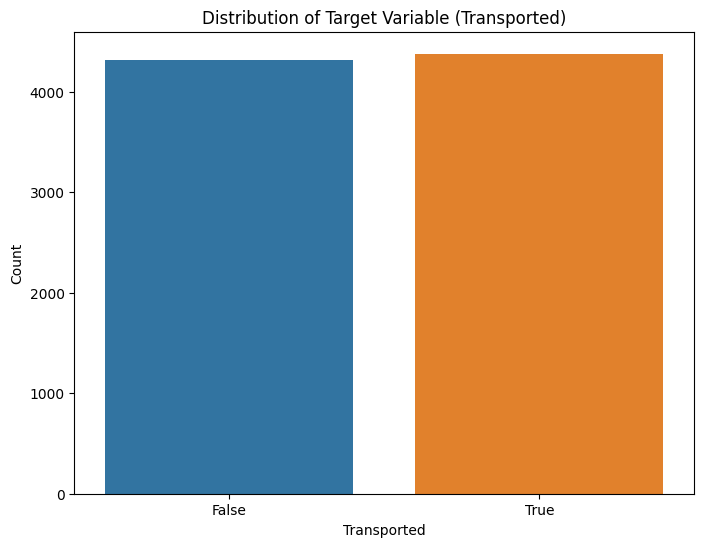

In [8]:
# Check the distribution of the target variable
print("\nTarget variable distribution:")
target_distribution = train_data['Transported'].value_counts(normalize=True) * 100
print(target_distribution)

# Visualize the target distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='Transported', data=train_data)
plt.title('Distribution of Target Variable (Transported)')
plt.ylabel('Count')
plt.show()

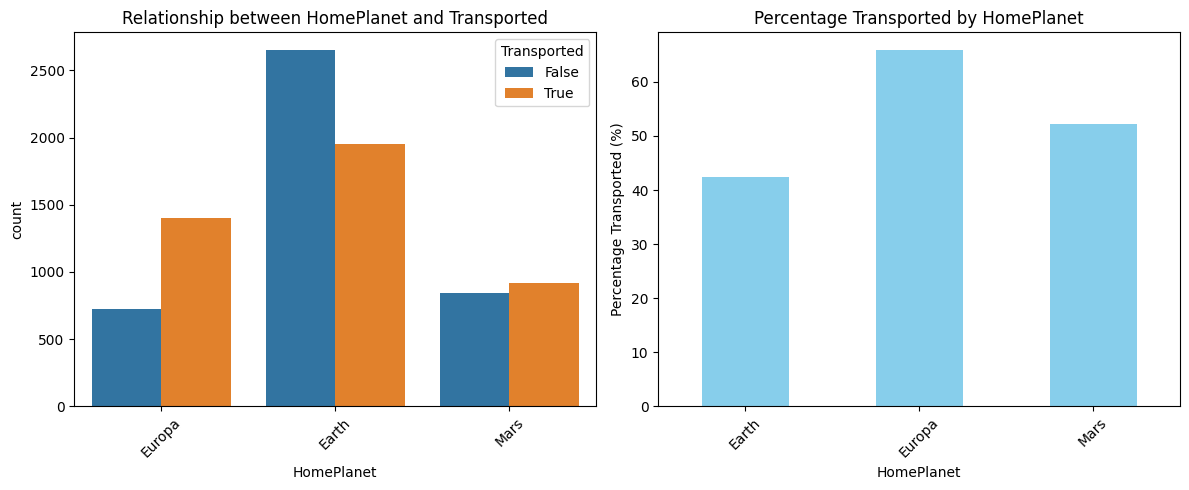

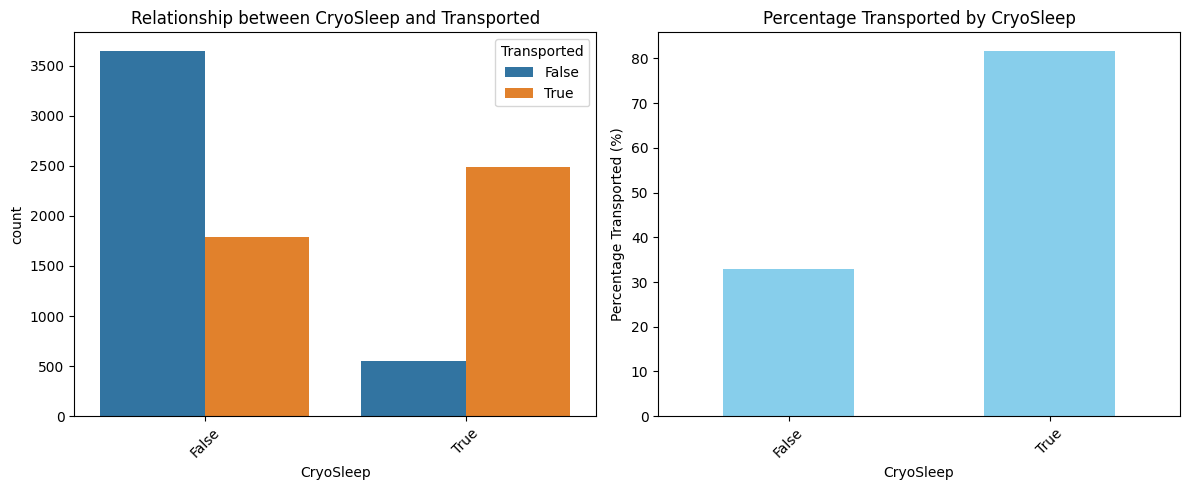

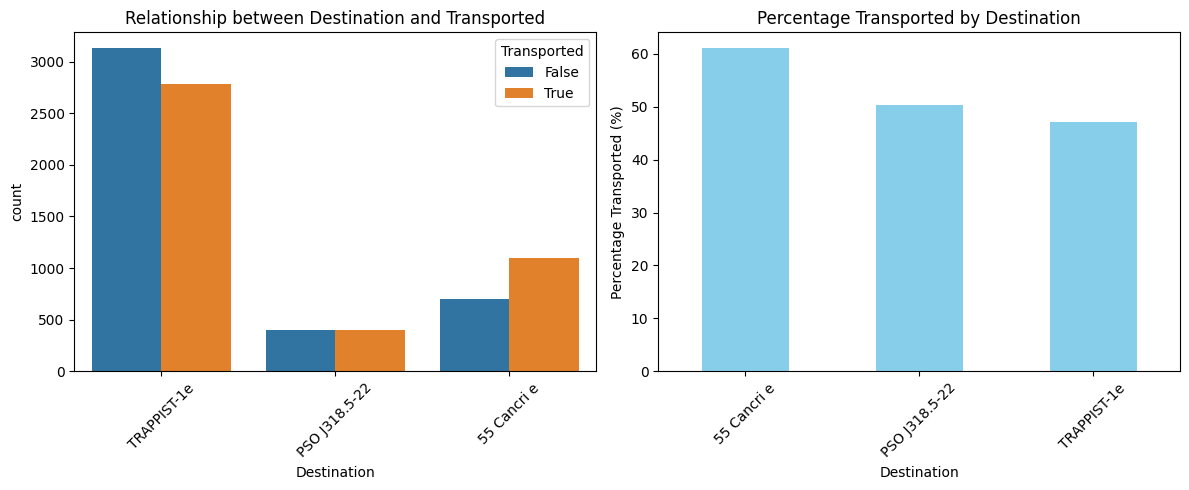

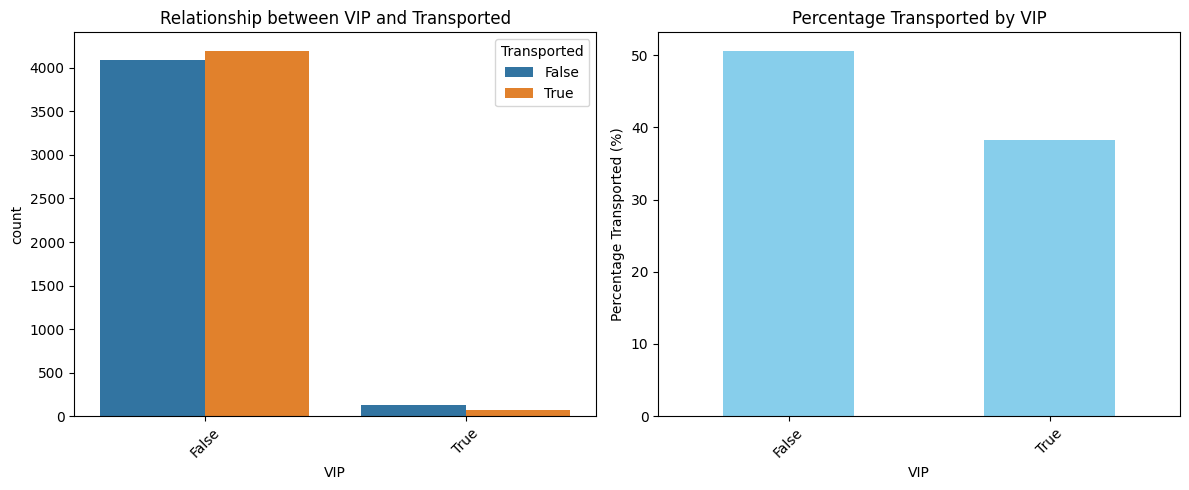

In [9]:
# Analyze categorical variables
categorical_features = ['HomePlanet', 'CryoSleep', 'Destination', 'VIP']

for feature in categorical_features:
    plt.figure(figsize=(12, 5))

    # Relationship with target
    plt.subplot(1, 2, 1)
    sns.countplot(x=feature, hue='Transported', data=train_data)
    plt.title(f'Relationship between {feature} and Transported')
    plt.xticks(rotation=45)

    # Percentage of transported by category
    plt.subplot(1, 2, 2)
    transport_rate = train_data.groupby(feature)['Transported'].mean() * 100
    transport_rate.plot(kind='bar', color='skyblue')
    plt.title(f'Percentage Transported by {feature}')
    plt.ylabel('Percentage Transported (%)')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

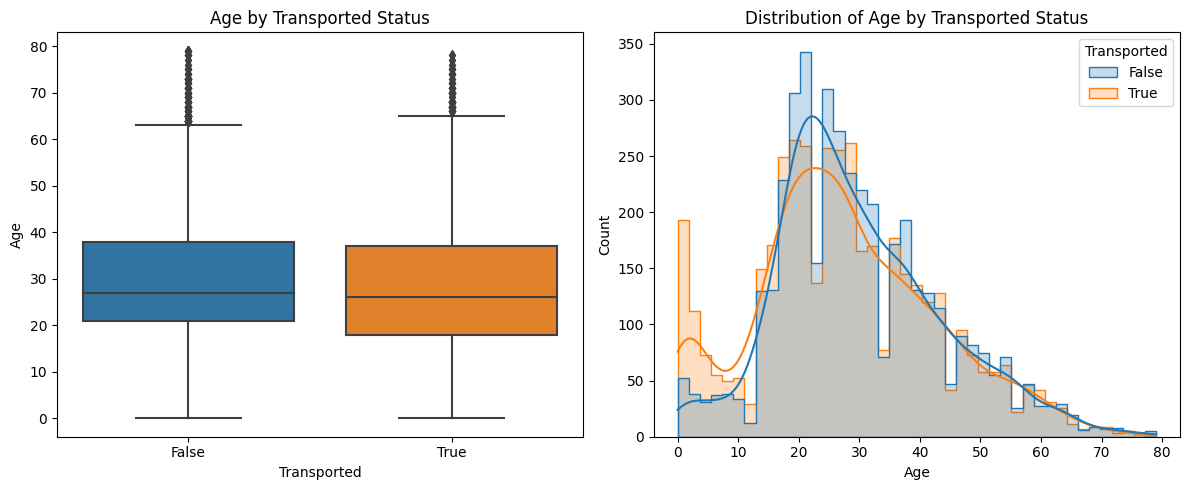

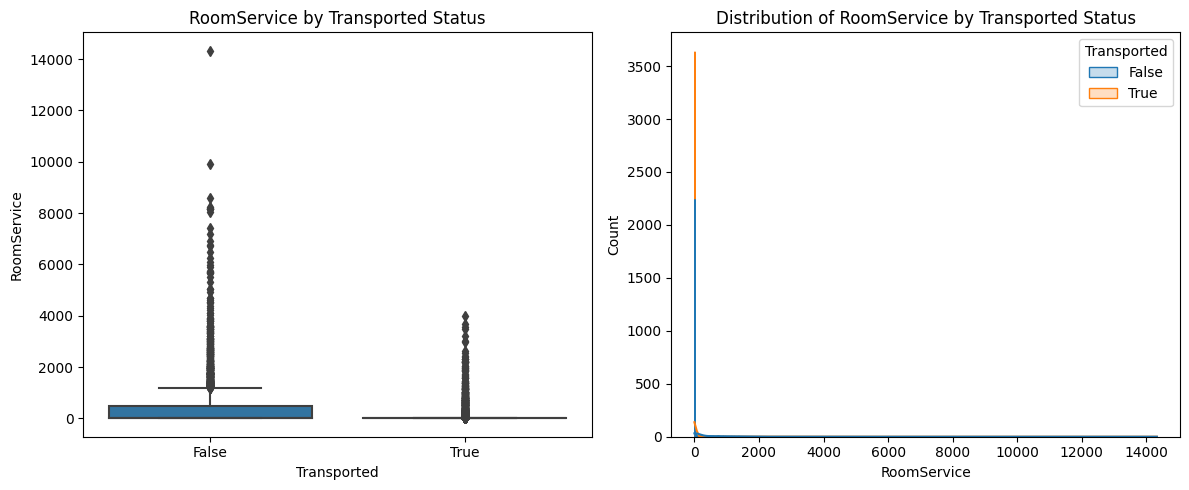

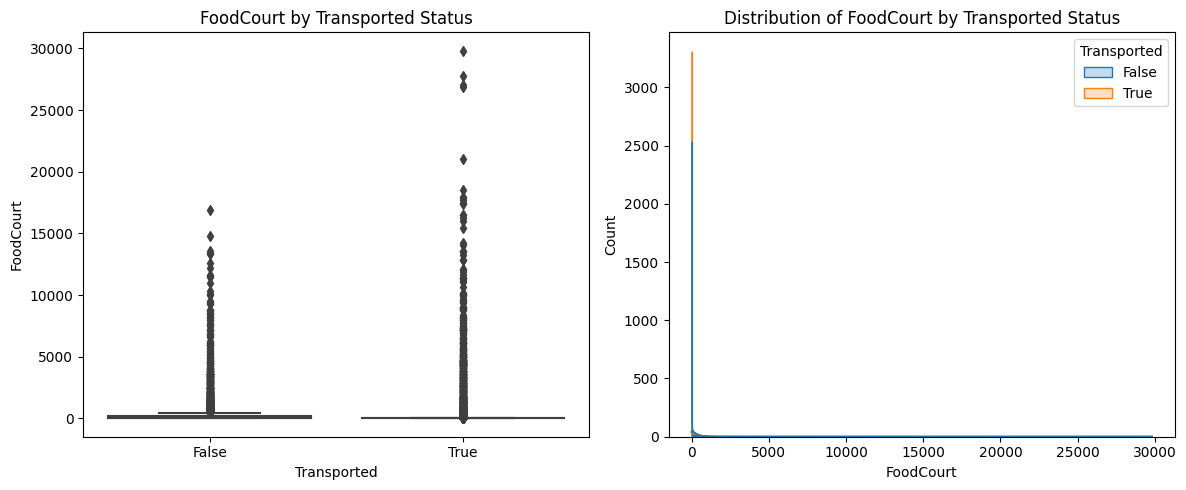

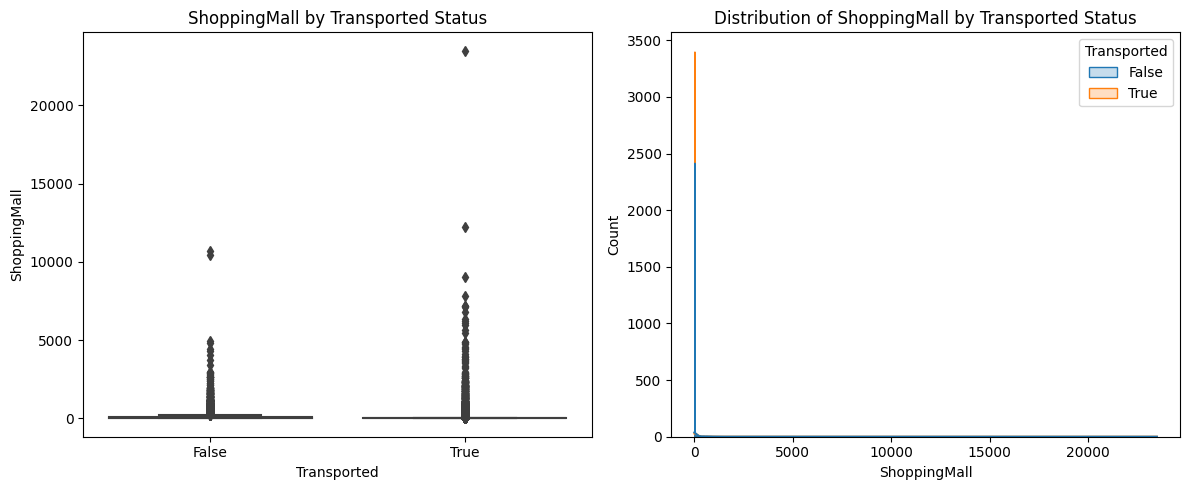

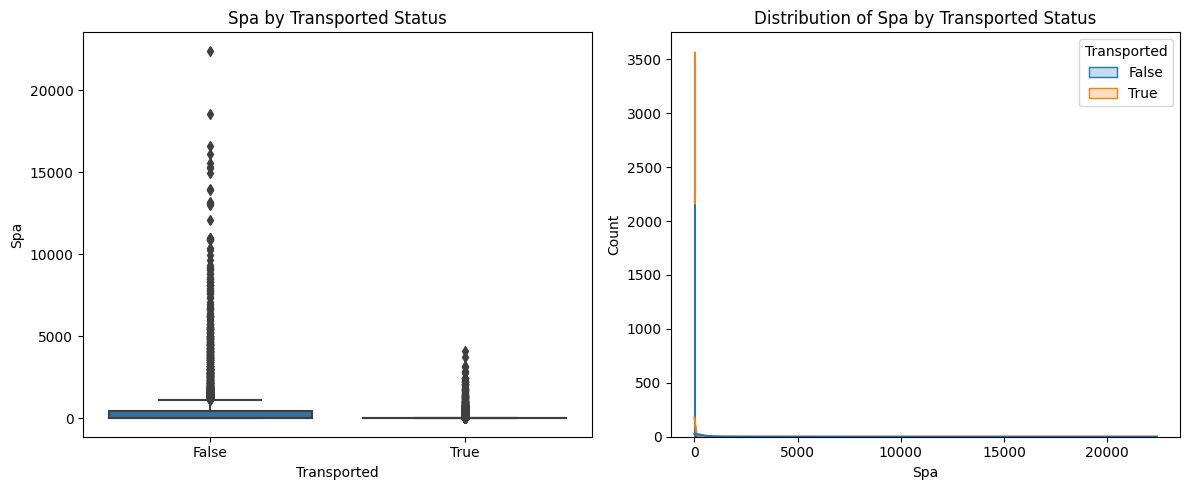

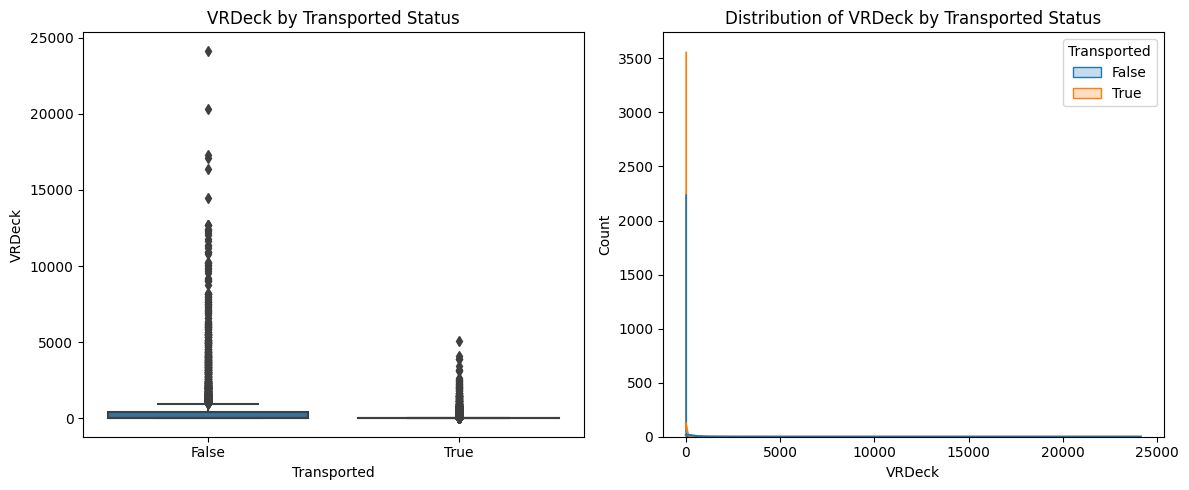

In [10]:
# Analyze numerical variables
numerical_features = ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']

# Distribution of numerical features
for feature in numerical_features:
    plt.figure(figsize=(12, 5))

    # Box plot by target
    plt.subplot(1, 2, 1)
    sns.boxplot(x='Transported', y=feature, data=train_data)
    plt.title(f'{feature} by Transported Status')

    # Histogram by target
    plt.subplot(1, 2, 2)
    sns.histplot(data=train_data, x=feature, hue='Transported', element='step', kde=True, common_norm=False)
    plt.title(f'Distribution of {feature} by Transported Status')

    plt.tight_layout()
    plt.show()


Analyzing Cabin information...


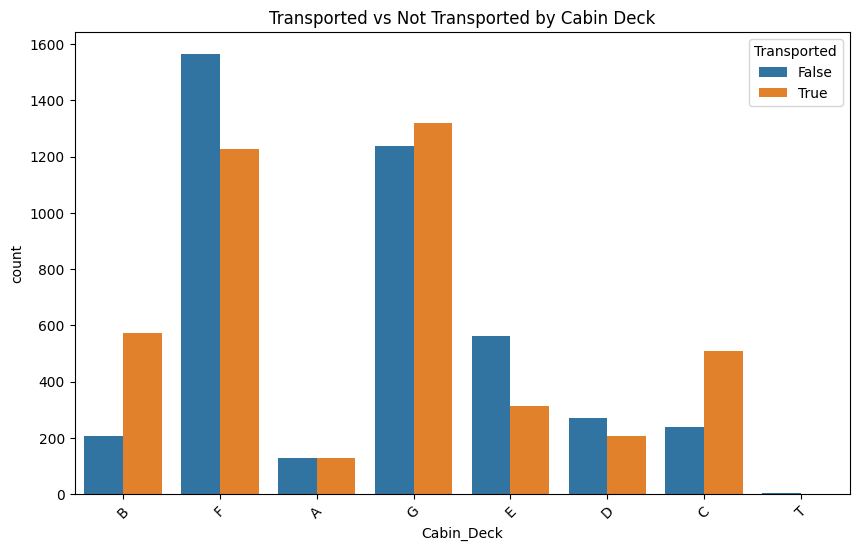

In [11]:
# Analyze cabin information
print("\nAnalyzing Cabin information...")
train_data['Cabin_Deck'] = train_data['Cabin'].str.split('/').str[0]
train_data['Cabin_Num'] = train_data['Cabin'].str.split('/').str[1]
train_data['Cabin_Side'] = train_data['Cabin'].str.split('/').str[2]

# Visualize cabin deck relationship with target
plt.figure(figsize=(10, 6))
sns.countplot(x='Cabin_Deck', hue='Transported', data=train_data)
plt.title('Transported vs Not Transported by Cabin Deck')
plt.xticks(rotation=45)
plt.show()

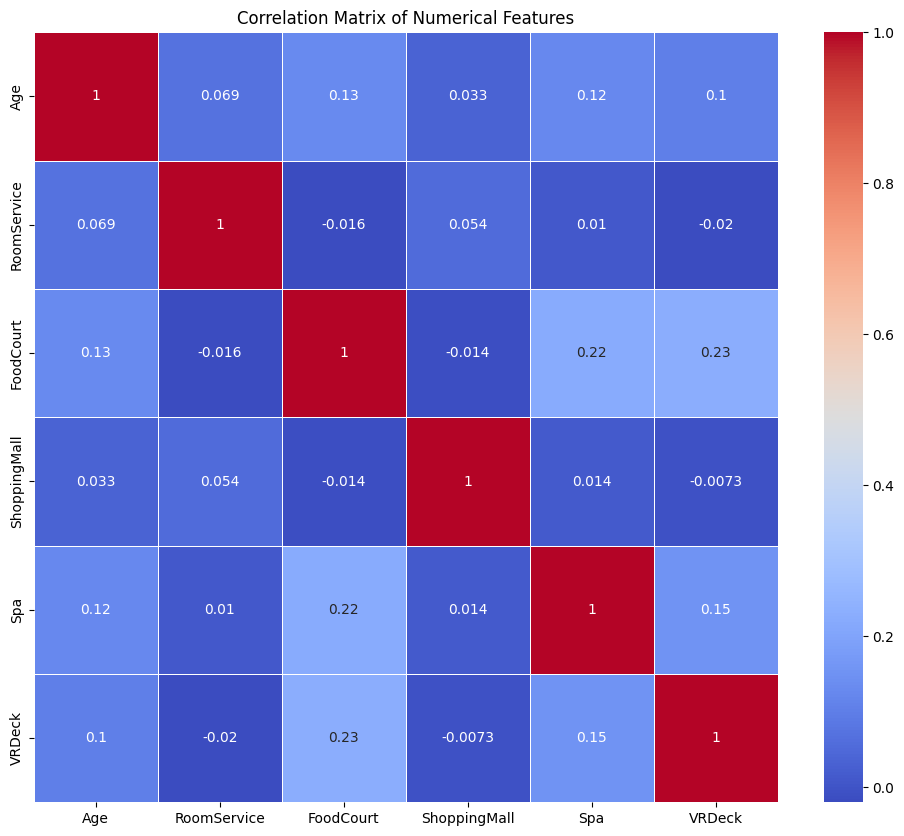

In [12]:
# Check correlations between numerical variables
plt.figure(figsize=(12, 10))
corr_matrix = train_data[numerical_features].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Numerical Features')
plt.show()


Analyzing group travel patterns...


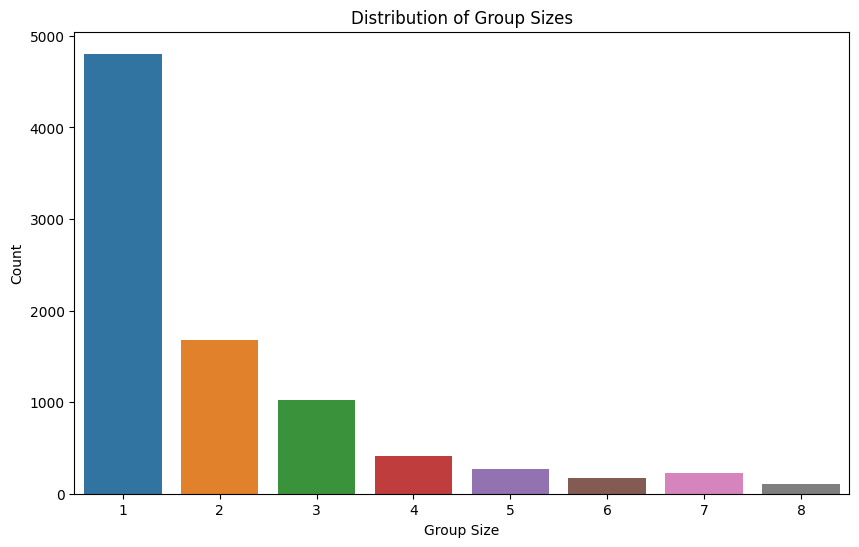

In [13]:
# Analyze group size based on PassengerId
print("\nAnalyzing group travel patterns...")
train_data['Group_Id'] = train_data['PassengerId'].str.split('_').str[0]
train_data['Group_Size'] = train_data.groupby('Group_Id')['PassengerId'].transform('count')

# Visualize group size distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='Group_Size', data=train_data, order=sorted(train_data['Group_Size'].unique()))
plt.title('Distribution of Group Sizes')
plt.xlabel('Group Size')
plt.ylabel('Count')
plt.show()

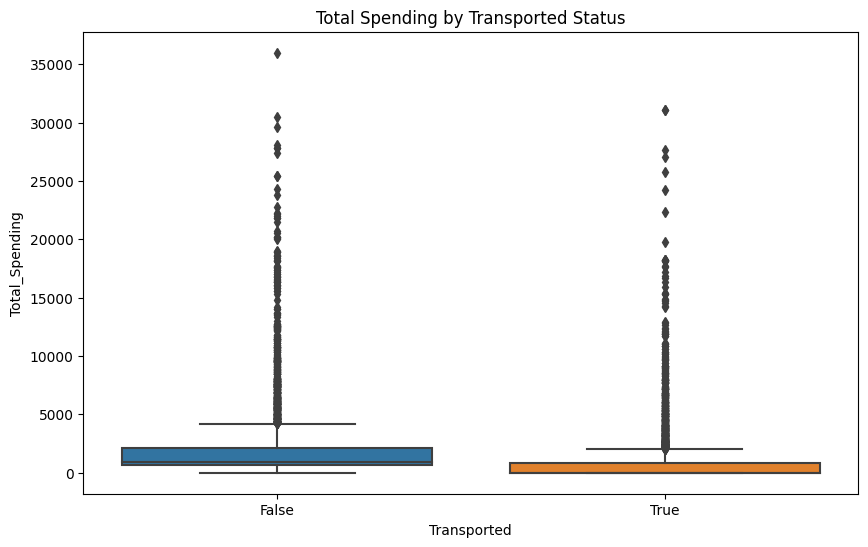

In [14]:
# Analyze total spending patterns
spending_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
train_data['Total_Spending'] = train_data[spending_cols].sum(axis=1)

plt.figure(figsize=(10, 6))
sns.boxplot(x='Transported', y='Total_Spending', data=train_data)
plt.title('Total Spending by Transported Status')
plt.show()

In [15]:
# Function to preprocess the data
def preprocess_data(data, is_training=True):
    df = data.copy()  # Copy data to avoid modifying the original
    passenger_ids = df['PassengerId']  # Extract passenger ID

    if is_training:
        y = df['Transported'].map({True: 1, False: 0})  # Save target for training data
        df.drop('Transported', axis=1, inplace=True)
    else:
        y = None

    # Process cabin information
    df['Has_Cabin'] = (~df['Cabin'].isna()).astype(int)
    cabin_parts = df['Cabin'].str.split('/', expand=True)

    if cabin_parts is not None and not cabin_parts.empty:
        if len(cabin_parts.columns) >= 3:
            df['Cabin_Deck'] = cabin_parts[0]
            df['Cabin_Num'] = pd.to_numeric(cabin_parts[1], errors='coerce')
            df['Cabin_Side'] = cabin_parts[2]
            df['Cabin_Num_Bin'] = pd.qcut(df['Cabin_Num'].fillna(df['Cabin_Num'].median()),
                                          q=10, labels=False, duplicates='drop')

    # Extract group information
    df['Group_Id'] = df['PassengerId'].str.split('_').str[0]
    df['Person_Num'] = df['PassengerId'].str.split('_').str[1].astype('int')
    df['Group_Size'] = df.groupby('Group_Id')['PassengerId'].transform('count')  # Calculate group size
    df['Is_Family'] = (df['Group_Size'] > 1).astype(int)  # Create family feature

    # Handle NaN values in spending columns
    spending_cols = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
    for col in spending_cols:
        df[f'Has_{col}'] = (~df[col].isna()).astype(int)

    cryo_mask = df['CryoSleep'] == True
    for col in spending_cols:
        df.loc[cryo_mask & df[col].isna(), col] = 0
        if 'HomePlanet' in df.columns and not df['HomePlanet'].isna().all():
            home_planet_medians = df.groupby('HomePlanet')[col].transform('median')
            df.loc[~cryo_mask & df[col].isna(), col] = df.loc[~cryo_mask & df[col].isna()].apply(
                lambda row: home_planet_medians[row.name] if not pd.isna(home_planet_medians[row.name]) else 0, axis=1)
        df[col] = df[col].fillna(0)

    df['Total_Spending'] = df[spending_cols].sum(axis=1)  # Calculate total spending

    # Log transform spending
    for col in spending_cols + ['Total_Spending']:
        df[f'{col}_Log'] = np.log1p(df[col])

    df['Has_Spending'] = (df['Total_Spending'] > 0).astype(int)  # Create binary flag for any spending

    # Handle missing values in categorical columns
    df['HomePlanet'] = df['HomePlanet'].fillna('Unknown')
    df['Destination'] = df['Destination'].fillna('Unknown')

    # Special handling for CryoSleep and VIP
    vip_mask = df['VIP'].isna()
    df.loc[vip_mask & (df['Total_Spending'] > df['Total_Spending'].quantile(0.75)), 'VIP'] = True
    df.loc[vip_mask, 'VIP'] = False

    cryo_mask = df['CryoSleep'].isna()
    df.loc[cryo_mask & (df['Total_Spending'] > 0), 'CryoSleep'] = False
    df.loc[cryo_mask, 'CryoSleep'] = True

    # Create interactions between features
    df['CryoSleep_VIP'] = df['CryoSleep'].astype(str) + '_' + df['VIP'].astype(str)
    df['HomePlanet_Destination'] = df['HomePlanet'].astype(str) + '_' + df['Destination'].astype(str)

    if 'Cabin_Deck' in df.columns:
        df['Deck_Destination'] = df['Cabin_Deck'].fillna('Unknown') + '_' + df['Destination']
        df['Deck_Side'] = df['Cabin_Deck'].fillna('Unknown') + '_' + df['Cabin_Side'].fillna('Unknown')

    # Ratio features
    df['Spending_Per_Person'] = df['Total_Spending'] / df['Group_Size'].replace(0, 1)
    total_mask = df['Total_Spending'] > 0
    for col in spending_cols:
        df[f'{col}_Ratio'] = 0
        if total_mask.sum() > 0:
            df.loc[total_mask, f'{col}_Ratio'] = df.loc[total_mask, col] / df.loc[total_mask, 'Total_Spending'].replace(0, 1)

    # Age processing
    if 'HomePlanet' in df.columns and not df['HomePlanet'].isna().all():
        for planet in df['HomePlanet'].unique():
            planet_mask = (df['HomePlanet'] == planet) & df['Age'].isna()
            planet_median = df.loc[df['HomePlanet'] == planet, 'Age'].median()
            if not pd.isna(planet_median):
                df.loc[planet_mask, 'Age'] = planet_median
    df['Age'] = df['Age'].fillna(df['Age'].median())
    
    # Handling outliers in Age - capping at 1st and 99th percentiles
    q_low = df['Age'].quantile(0.01)
    q_high = df['Age'].quantile(0.99)
    df['Age_Capped'] = df['Age'].clip(q_low, q_high)
    
    df['Age_Group'] = pd.cut(df['Age_Capped'], bins=[0, 12, 18, 25, 35, 50, 100], labels=['Child', 'Teenager', 'Young Adult', 'Adult', 'Middle Aged', 'Senior'])
    df['Is_Child'] = (df['Age_Capped'] < 18).astype(int)
    df['Is_Senior'] = (df['Age_Capped'] > 50).astype(int)

    # Group-level statistics
    for col in ['Age'] + spending_cols:
        group_mean = df.groupby('Group_Id')[col].transform('mean')
        group_std = df.groupby('Group_Id')[col].transform('std')
        df[f'Group_{col}_Mean'] = group_mean
        df[f'Group_{col}_Std'] = group_std.fillna(0)
        df[f'{col}_Group_Deviation'] = df[col] - group_mean

    # Calculate the ratio of various expenses to total spending
    df['RoomService_Ratio'] = df['RoomService'] / df['Total_Spending'].replace(0, 1)
    df['FoodCourt_Ratio'] = df['FoodCourt'] / df['Total_Spending'].replace(0, 1)
    df['ShoppingMall_Ratio'] = df['ShoppingMall'] / df['Total_Spending'].replace(0, 1)
    df['Spa_Ratio'] = df['Spa'] / df['Total_Spending'].replace(0, 1)
    df['VRDeck_Ratio'] = df['VRDeck'] / df['Total_Spending'].replace(0, 1)
    
    # Count group members in CryoSleep
    df['Group_CryoSleep_Count'] = df.groupby('Group_Id')['CryoSleep'].transform('sum')
    
    # Count group members who are VIP
    df['Group_VIP_Count'] = df.groupby('Group_Id')['VIP'].transform('sum')
    
    # Calculate the mean age of group members
    df['Group_Age_Mean'] = df.groupby('Group_Id')['Age'].transform('mean')
    
    # Calculate the standard deviation of age in groups, fill NaN with 0
    df['Group_Age_Std'] = df.groupby('Group_Id')['Age'].transform('std').fillna(0)
    
    # Calculate the total spending of group members
    df['Group_Total_Spending_Mean'] = df.groupby('Group_Id')['Total_Spending'].transform('mean')
    
    # Calculate the ratio of total spending to group mean spending
    df['Spending_to_Group_Mean'] = df['Total_Spending'] / df['Group_Total_Spending_Mean'].replace(0, 1)
    
    # Handling outliers in spending columns
    for col in spending_cols + ['Total_Spending']:
        q_low = df[col].quantile(0.01)
        q_high = df[col].quantile(0.99)
        df[f'{col}_Capped'] = df[col].clip(q_low, q_high)

    df['CryoSleep_Age'] = df['CryoSleep'].astype(int) * df['Age']
    df['VIP_Spending'] = df['VIP'].astype(int) * df['Total_Spending']
    df['CryoSleep_Group_Size'] = df['CryoSleep'].astype(int) * df['Group_Size']
    
    # Create polynomial features for important numerical variables
    df['Age_Squared'] = df['Age'] ** 2
    df['Total_Spending_Squared'] = df['Total_Spending'] ** 2
    
    # More detailed age groups for better granularity
    df['Age_Detailed'] = pd.cut(df['Age_Capped'], 
                               bins=[0, 8, 12, 16, 20, 25, 30, 35, 40, 50, 60, 100], 
                               labels=['Infant', 'Child', 'Preteen', 'Teen', 'Young Adult', 
                                      'Adult_25_30', 'Adult_30_35', 'Adult_35_40', 
                                      'Middle_Aged', 'Senior', 'Elder'])
    
    # Create spending patterns features
    df['Spending_Pattern'] = 'None'
    # High room service and food court
    mask = (df['RoomService'] > df['RoomService'].quantile(0.75)) & (df['FoodCourt'] > df['FoodCourt'].quantile(0.75))
    df.loc[mask, 'Spending_Pattern'] = 'Room_Food'
    # High shopping and spa
    mask = (df['ShoppingMall'] > df['ShoppingMall'].quantile(0.75)) & (df['Spa'] > df['Spa'].quantile(0.75))
    df.loc[mask, 'Spending_Pattern'] = 'Shop_Spa'
    # High VRDeck
    mask = df['VRDeck'] > df['VRDeck'].quantile(0.75)
    df.loc[mask, 'Spending_Pattern'] = 'VR'
    # Balanced spending
    std_spending = df[spending_cols].std(axis=1)
    mean_spending = df[spending_cols].mean(axis=1)
    cv = std_spending / mean_spending.replace(0, 1)
    mask = (cv < 0.5) & (mean_spending > 0)
    df.loc[mask, 'Spending_Pattern'] = 'Balanced'
    
    # Spending diversity
    df['Spending_Categories'] = df[spending_cols].apply(lambda x: sum(x > 0), axis=1)
    
    # Spending concentration
    for col in spending_cols:
        df[f'{col}_Concentration'] = df[col] / df['Total_Spending'].replace(0, 1)
    
    # Group homogeneity
    for col in ['CryoSleep', 'VIP', 'HomePlanet', 'Destination']:
        if col in df.columns:
            # Calculate the most common value in each group
            most_common = df.groupby('Group_Id')[col].agg(lambda x: x.value_counts().index[0] if len(x.value_counts()) > 0 else None)
            # Map it back to each passenger
            df[f'Group_{col}_Common'] = df['Group_Id'].map(most_common)
            # A flag for whether this passenger matches the most common value
            df[f'Matches_Group_{col}'] = (df[col] == df[f'Group_{col}_Common']).astype(int)
    
    # Drop columns not used in the model
    columns_to_drop = ['PassengerId', 'Name', 'Cabin', 'Group_Id']
    df.drop(columns_to_drop, axis=1, inplace=True)

    return df, y, passenger_ids

In [16]:
# Preprocess the training and testing data
train_processed, y_train, train_passenger_ids = preprocess_data(
    train_data, is_training=True)
test_processed, _, test_passenger_ids = preprocess_data(
    test_data, is_training=False)

# Display the processed data info
print("\nProcessed training data shape:", train_processed.shape)
print("Processed testing data shape:", test_processed.shape)


Processed training data shape: (8693, 94)
Processed testing data shape: (4277, 94)


In [17]:
# Identify feature types
categorical_features = [col for col in train_processed.columns if train_processed[col].dtype == 'object' or
                        col in ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Cabin_Deck', 'Cabin_Side',
                                'CryoSleep_VIP', 'HomePlanet_Destination', 'Age_Group', 'Deck_Destination',
                                'Deck_Side', 'Age_Detailed', 'Spending_Pattern']]

numerical_features = [
    col for col in train_processed.columns if col not in categorical_features]

print("\nCategorical features:", categorical_features)
print("\nNumerical features:", numerical_features)


Categorical features: ['HomePlanet', 'CryoSleep', 'Destination', 'VIP', 'Cabin_Deck', 'Cabin_Side', 'CryoSleep_VIP', 'HomePlanet_Destination', 'Deck_Destination', 'Deck_Side', 'Age_Group', 'Group_CryoSleep_Count', 'Group_VIP_Count', 'Age_Detailed', 'Spending_Pattern', 'Group_HomePlanet_Common', 'Group_Destination_Common']

Numerical features: ['Age', 'RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck', 'Cabin_Num', 'Group_Size', 'Total_Spending', 'Has_Cabin', 'Cabin_Num_Bin', 'Person_Num', 'Is_Family', 'Has_RoomService', 'Has_FoodCourt', 'Has_ShoppingMall', 'Has_Spa', 'Has_VRDeck', 'RoomService_Log', 'FoodCourt_Log', 'ShoppingMall_Log', 'Spa_Log', 'VRDeck_Log', 'Total_Spending_Log', 'Has_Spending', 'Spending_Per_Person', 'RoomService_Ratio', 'FoodCourt_Ratio', 'ShoppingMall_Ratio', 'Spa_Ratio', 'VRDeck_Ratio', 'Age_Capped', 'Is_Child', 'Is_Senior', 'Group_Age_Mean', 'Group_Age_Std', 'Age_Group_Deviation', 'Group_RoomService_Mean', 'Group_RoomService_Std', 'RoomService_Group_De

In [18]:
# Create preprocessing pipelines for numerical and categorical features
numerical_transformer = Pipeline(steps=[
    ('knn_imputer', KNNImputer(n_neighbors=5)),
    ('standard_scaler', StandardScaler()),
    ('robust_scaler', RobustScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Apply preprocessing
X_train_full = preprocessor.fit_transform(train_processed)
X_test_transformed = preprocessor.transform(test_processed)

print(f"\nDimensions after preprocessing: {X_train_full.shape}")


Dimensions after preprocessing: (8693, 209)


In [19]:
# Perform cross-validation before feature selection to evaluate baseline performance
print("\nPerforming initial cross-validation...")
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
base_model = lgb.LGBMClassifier(random_state=RANDOM_STATE)

cv_scores = cross_val_score(base_model, X_train_full, y_train, cv=cv, scoring='accuracy', n_jobs=-1)

print(f"Initial CV Scores: {cv_scores}")
print(f"Mean CV Score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")


Performing initial cross-validation...
Initial CV Scores: [0.81483611 0.81253594 0.80391029 0.82508631 0.79516686]
Mean CV Score: 0.8103 (+/- 0.0203)


In [20]:
# Feature selection to reduce dimensionality and prevent overfitting
print("\nPerforming feature selection...")
k_best = min(100, X_train_full.shape[1])  # Select top k features
selector = SelectKBest(f_classif, k=k_best)
X_train_selected = selector.fit_transform(X_train_full, y_train)
X_test_selected = selector.transform(X_test_transformed)

print(f"Dimensions after feature selection: {X_train_selected.shape}")


Performing feature selection...
Dimensions after feature selection: (8693, 100)


In [21]:
# Split training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_selected, y_train, test_size=0.2, random_state=RANDOM_STATE, stratify=y_train)

# Convert y values to numpy arrays for consistency
y_train_array = np.array(y_train)
y_val_np = np.array(y_val)

print("\nTraining set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)


Training set shape: (6954, 100)
Validation set shape: (1739, 100)


In [22]:
# Define the objective function for Optuna optimization with overfitting prevention
def objective_lgb(trial):
    param = {
        'objective': 'binary',                # Binary classification
        'metric': ['binary_logloss', 'auc'],  # Binary log loss and AUC metric for evaluation
        'verbosity': -1,                      # Reduce verbosity
        'boosting_type': 'gbdt',              # Gradient Boosting Decision Tree

        # Regularization parameters - for reducing overfitting
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-9, 1e-5, log=True),  # L1 regularization - reduced range
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-9, 1e-5, log=True),  # L2 regularization - reduced range

        # Tree structure parameters - balance between model complexity and generalization
        'num_leaves': trial.suggest_int('num_leaves', 2, 31),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.7, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.7, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'min_child_samples': trial.suggest_int('min_child_samples', 100, 300),
        'max_depth': trial.suggest_int('max_depth', 10, 15),
        
        # Learning parameters - control training process
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.1),
        'n_estimators': trial.suggest_int('n_estimators', 1000, 5000),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 100),
        
        # Additional fine-tuning parameters
        'min_split_gain': trial.suggest_float('min_split_gain', 0.01, 0.1),
        'max_bin': trial.suggest_int('max_bin', 200, 300),
        'subsample_for_bin': trial.suggest_int('subsample_for_bin', 200000, 300000),
        'path_smooth': trial.suggest_float('path_smooth', 0.0, 0.2),
        'cat_smooth': trial.suggest_float('cat_smooth', 10.0, 100.0),
        'cat_l2': trial.suggest_float('cat_l2', 1.0, 20.0),
        'max_cat_to_onehot': trial.suggest_int('max_cat_to_onehot', 1, 10),
        
        # Class balancing parameters
        'pos_bagging_fraction': trial.suggest_float('pos_bagging_fraction', 0.7, 1.0),
        'neg_bagging_fraction': trial.suggest_float('neg_bagging_fraction', 0.7, 1.0),
        'max_delta_step': trial.suggest_float('max_delta_step', 0.1, 2.0)
    }

    # Enhanced Cross-Validation with multiple metrics
    cv_outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    cv_scores_accuracy = []
    cv_scores_auc = []
    cv_scores_f1 = []

    for train_idx, valid_idx in cv_outer.split(X_train, y_train_array):
        X_train_cv, X_valid_cv = X_train[train_idx], X_train[valid_idx]
        y_train_cv, y_valid_cv = y_train_array[train_idx], y_train_array[valid_idx]

        train_data = lgb.Dataset(X_train_cv, label=y_train_cv)
        valid_data = lgb.Dataset(X_valid_cv, label=y_valid_cv, reference=train_data)
        
        # Early stopping callback
        callbacks = [
            lgb.early_stopping(stopping_rounds=100),
            lgb.log_evaluation(period=0)
        ]

        # Train the model
        model = lgb.train(
            param,
            train_data,
            valid_sets=[valid_data],
            num_boost_round=5000,
            callbacks=callbacks
        )

        # Make predictions
        y_pred = model.predict(X_valid_cv)
        y_pred_binary = (y_pred > 0.5).astype(int)
        
        # Calculate multiple metrics
        accuracy = accuracy_score(y_valid_cv, y_pred_binary)
        auc = roc_auc_score(y_valid_cv, y_pred)
        f1 = f1_score(y_valid_cv, y_pred_binary)

        cv_scores_accuracy.append(accuracy)
        cv_scores_auc.append(auc)
        cv_scores_f1.append(f1)
        
    # Calculate mean scores
    mean_accuracy = np.mean(cv_scores_accuracy)
    mean_auc = np.mean(cv_scores_auc)
    mean_f1 = np.mean(cv_scores_f1)

    # Use a weighted combination of metrics for optimization
    final_score = (mean_accuracy * 0.80 + mean_auc * 0.10 + mean_f1 * 0.10)

    # Store additional metrics in the trial
    trial.set_user_attr('accuracy', mean_accuracy)
    trial.set_user_attr('auc', mean_auc)
    trial.set_user_attr('f1', mean_f1)

    return final_score

In [23]:
# Run Optuna optimization for LightGBM
print("\nOptimizing LightGBM hyperparameters with enhanced cross-validation...")
lgb_study = optuna.create_study(direction='maximize')
lgb_study.optimize(objective_lgb, n_trials=50)

print("\nBest trial:")
print("\tValue: ", lgb_study.best_trial.value)
print("\tAccuracy: ", lgb_study.best_trial.user_attrs['accuracy'])
print("\tAUC: ", lgb_study.best_trial.user_attrs['auc'])
print("\tF1: ", lgb_study.best_trial.user_attrs['f1'])
print("\tParams: ")
for key, value in lgb_study.best_trial.params.items():
    print(f"\t{key}: {value}")

[I 2025-03-24 05:20:57,392] A new study created in memory with name: no-name-5d1845ab-660b-4a1f-9d7a-bf219dacb043



Optimizing LightGBM hyperparameters with enhanced cross-validation...
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[2201]	valid_0's binary_logloss: 0.4025	valid_0's auc: 0.896506
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[2201]	valid_0's binary_logloss: 0.40281	valid_0's auc: 0.896366
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[2201]	valid_0's binary_logloss: 0.413654	valid_0's auc: 0.891438
Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[2201]	valid_0's binary_logloss: 0.418553	valid_0's auc: 0.887671
Training until validation scores don't improve for 100 rounds


[I 2025-03-24 05:21:26,037] Trial 0 finished with value: 0.8100881600937069 and parameters: {'lambda_l1': 2.5942388374605734e-08, 'lambda_l2': 1.1796283067252953e-06, 'num_leaves': 7, 'feature_fraction': 0.9675813677816528, 'bagging_fraction': 0.7120113310466906, 'bagging_freq': 9, 'min_child_samples': 169, 'max_depth': 10, 'learning_rate': 0.012091505001554106, 'n_estimators': 2201, 'min_data_in_leaf': 29, 'min_split_gain': 0.014594121572769403, 'max_bin': 212, 'subsample_for_bin': 239916, 'path_smooth': 0.1572077551884078, 'cat_smooth': 46.50985998020007, 'cat_l2': 2.101475717507851, 'max_cat_to_onehot': 1, 'pos_bagging_fraction': 0.8269648444123875, 'neg_bagging_fraction': 0.9609344110440317, 'max_delta_step': 0.15930674453411703}. Best is trial 0 with value: 0.8100881600937069.


Early stopping, best iteration is:
[2007]	valid_0's binary_logloss: 0.411305	valid_0's auc: 0.89255
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[305]	valid_0's binary_logloss: 0.389476	valid_0's auc: 0.900568
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[521]	valid_0's binary_logloss: 0.388362	valid_0's auc: 0.900153
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[265]	valid_0's binary_logloss: 0.398853	valid_0's auc: 0.897089
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[395]	valid_0's binary_logloss: 0.409755	valid_0's auc: 0.888941
Training until validation scores don't improve for 100 rounds


[I 2025-03-24 05:21:35,997] Trial 1 finished with value: 0.8160431784089792 and parameters: {'lambda_l1': 1.3581525149736996e-06, 'lambda_l2': 3.967791500806379e-06, 'num_leaves': 15, 'feature_fraction': 0.8815451498839012, 'bagging_fraction': 0.9510820922491283, 'bagging_freq': 6, 'min_child_samples': 265, 'max_depth': 15, 'learning_rate': 0.022930025675425725, 'n_estimators': 4754, 'min_data_in_leaf': 81, 'min_split_gain': 0.044384991264914915, 'max_bin': 230, 'subsample_for_bin': 213569, 'path_smooth': 0.032337987008775014, 'cat_smooth': 47.929364364459666, 'cat_l2': 4.58097663423896, 'max_cat_to_onehot': 5, 'pos_bagging_fraction': 0.8011038779077425, 'neg_bagging_fraction': 0.8167445789681127, 'max_delta_step': 1.9777154316715855}. Best is trial 1 with value: 0.8160431784089792.


Early stopping, best iteration is:
[347]	valid_0's binary_logloss: 0.394786	valid_0's auc: 0.899029
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[103]	valid_0's binary_logloss: 0.395707	valid_0's auc: 0.898537
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[144]	valid_0's binary_logloss: 0.389136	valid_0's auc: 0.90165
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[71]	valid_0's binary_logloss: 0.407183	valid_0's auc: 0.894711
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[121]	valid_0's binary_logloss: 0.406444	valid_0's auc: 0.892729
Training until validation scores don't improve for 100 rounds


[I 2025-03-24 05:21:40,049] Trial 2 finished with value: 0.812370553214208 and parameters: {'lambda_l1': 1.9862911062461814e-07, 'lambda_l2': 2.13403781654075e-07, 'num_leaves': 16, 'feature_fraction': 0.9106170340964017, 'bagging_fraction': 0.9184715385199016, 'bagging_freq': 7, 'min_child_samples': 189, 'max_depth': 11, 'learning_rate': 0.09487396134064435, 'n_estimators': 4332, 'min_data_in_leaf': 65, 'min_split_gain': 0.03760838749041042, 'max_bin': 244, 'subsample_for_bin': 248005, 'path_smooth': 0.1387136277214079, 'cat_smooth': 76.57590668173644, 'cat_l2': 5.9956252153125105, 'max_cat_to_onehot': 8, 'pos_bagging_fraction': 0.7707737247367554, 'neg_bagging_fraction': 0.8943529438882247, 'max_delta_step': 0.8333873852351759}. Best is trial 1 with value: 0.8160431784089792.


Early stopping, best iteration is:
[91]	valid_0's binary_logloss: 0.395926	valid_0's auc: 0.898983
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[218]	valid_0's binary_logloss: 0.394114	valid_0's auc: 0.900835
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[247]	valid_0's binary_logloss: 0.388053	valid_0's auc: 0.902212
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[171]	valid_0's binary_logloss: 0.406751	valid_0's auc: 0.895989
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[107]	valid_0's binary_logloss: 0.409811	valid_0's auc: 0.891761
Training until validation scores don't improve for 100 rounds


[I 2025-03-24 05:21:44,215] Trial 3 finished with value: 0.8109916749968096 and parameters: {'lambda_l1': 1.234065178103748e-07, 'lambda_l2': 4.714500085970218e-09, 'num_leaves': 10, 'feature_fraction': 0.8977845823646563, 'bagging_fraction': 0.941094287132419, 'bagging_freq': 6, 'min_child_samples': 155, 'max_depth': 15, 'learning_rate': 0.06567459814775997, 'n_estimators': 1390, 'min_data_in_leaf': 71, 'min_split_gain': 0.027990071013684108, 'max_bin': 239, 'subsample_for_bin': 268873, 'path_smooth': 0.09857234301422689, 'cat_smooth': 99.1640575860426, 'cat_l2': 14.728954657634349, 'max_cat_to_onehot': 8, 'pos_bagging_fraction': 0.7437660147480037, 'neg_bagging_fraction': 0.9936894603482189, 'max_delta_step': 1.3292876971006287}. Best is trial 1 with value: 0.8160431784089792.


Early stopping, best iteration is:
[168]	valid_0's binary_logloss: 0.399223	valid_0's auc: 0.898296
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[245]	valid_0's binary_logloss: 0.392246	valid_0's auc: 0.900584
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[432]	valid_0's binary_logloss: 0.392708	valid_0's auc: 0.899255
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[347]	valid_0's binary_logloss: 0.403878	valid_0's auc: 0.894308
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[503]	valid_0's binary_logloss: 0.403638	valid_0's auc: 0.893578
Training until validation scores don't improve for 100 rounds


[I 2025-03-24 05:21:48,986] Trial 4 finished with value: 0.8151732466206227 and parameters: {'lambda_l1': 1.6133029874727972e-08, 'lambda_l2': 3.5148849068997683e-09, 'num_leaves': 6, 'feature_fraction': 0.8996179758723439, 'bagging_fraction': 0.8571851958365735, 'bagging_freq': 7, 'min_child_samples': 201, 'max_depth': 11, 'learning_rate': 0.05594910770307472, 'n_estimators': 2768, 'min_data_in_leaf': 91, 'min_split_gain': 0.07784478823332869, 'max_bin': 244, 'subsample_for_bin': 230890, 'path_smooth': 0.03504663741390346, 'cat_smooth': 80.6836795902436, 'cat_l2': 10.722219006376271, 'max_cat_to_onehot': 9, 'pos_bagging_fraction': 0.8755550733772866, 'neg_bagging_fraction': 0.793482679863783, 'max_delta_step': 1.723761015074366}. Best is trial 1 with value: 0.8160431784089792.


Early stopping, best iteration is:
[379]	valid_0's binary_logloss: 0.400188	valid_0's auc: 0.896572
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[312]	valid_0's binary_logloss: 0.396512	valid_0's auc: 0.89902
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[354]	valid_0's binary_logloss: 0.396757	valid_0's auc: 0.899068
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[309]	valid_0's binary_logloss: 0.401912	valid_0's auc: 0.896148
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[306]	valid_0's binary_logloss: 0.41576	valid_0's auc: 0.888789
Training until validation scores don't improve for 100 rounds


[I 2025-03-24 05:21:58,059] Trial 5 finished with value: 0.8122559630655598 and parameters: {'lambda_l1': 4.7458567372185264e-07, 'lambda_l2': 4.27427775302616e-07, 'num_leaves': 28, 'feature_fraction': 0.8331978433981562, 'bagging_fraction': 0.8874062895902635, 'bagging_freq': 9, 'min_child_samples': 106, 'max_depth': 13, 'learning_rate': 0.05106008832493585, 'n_estimators': 1525, 'min_data_in_leaf': 87, 'min_split_gain': 0.037612465909244795, 'max_bin': 228, 'subsample_for_bin': 233205, 'path_smooth': 0.08836404251855055, 'cat_smooth': 46.4024584608208, 'cat_l2': 14.426360639092515, 'max_cat_to_onehot': 7, 'pos_bagging_fraction': 0.9067392794522375, 'neg_bagging_fraction': 0.7536723956858395, 'max_delta_step': 0.34333334027097734}. Best is trial 1 with value: 0.8160431784089792.


Early stopping, best iteration is:
[283]	valid_0's binary_logloss: 0.406894	valid_0's auc: 0.894905
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1160]	valid_0's binary_logloss: 0.395828	valid_0's auc: 0.899068
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1164]	valid_0's binary_logloss: 0.395852	valid_0's auc: 0.900234
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1177]	valid_0's binary_logloss: 0.407494	valid_0's auc: 0.893407
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1264]	valid_0's binary_logloss: 0.411865	valid_0's auc: 0.891309
Training until validation scores don't improve for 100 rounds


[I 2025-03-24 05:22:27,989] Trial 6 finished with value: 0.8161158047002957 and parameters: {'lambda_l1': 1.4348372420118088e-09, 'lambda_l2': 2.4584281243764274e-09, 'num_leaves': 19, 'feature_fraction': 0.7116359696360807, 'bagging_fraction': 0.9681533501100023, 'bagging_freq': 4, 'min_child_samples': 136, 'max_depth': 10, 'learning_rate': 0.023035299247772038, 'n_estimators': 2530, 'min_data_in_leaf': 33, 'min_split_gain': 0.06120157925572802, 'max_bin': 296, 'subsample_for_bin': 221434, 'path_smooth': 0.12403373221012724, 'cat_smooth': 57.156486788562354, 'cat_l2': 19.53511197162533, 'max_cat_to_onehot': 8, 'pos_bagging_fraction': 0.9549121726215817, 'neg_bagging_fraction': 0.7949197098962705, 'max_delta_step': 0.17887655820028542}. Best is trial 6 with value: 0.8161158047002957.


Early stopping, best iteration is:
[1200]	valid_0's binary_logloss: 0.403666	valid_0's auc: 0.896484
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[81]	valid_0's binary_logloss: 0.392471	valid_0's auc: 0.899944
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[76]	valid_0's binary_logloss: 0.392103	valid_0's auc: 0.899646
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[85]	valid_0's binary_logloss: 0.405655	valid_0's auc: 0.893971
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[71]	valid_0's binary_logloss: 0.404745	valid_0's auc: 0.892173
Training until validation scores don't improve for 100 rounds


[I 2025-03-24 05:22:33,714] Trial 7 finished with value: 0.8138692375718289 and parameters: {'lambda_l1': 2.5331160945914794e-06, 'lambda_l2': 4.178422578139426e-09, 'num_leaves': 28, 'feature_fraction': 0.9181245716226432, 'bagging_fraction': 0.9881518106617693, 'bagging_freq': 3, 'min_child_samples': 277, 'max_depth': 13, 'learning_rate': 0.08977689561107763, 'n_estimators': 4299, 'min_data_in_leaf': 22, 'min_split_gain': 0.09408385953148402, 'max_bin': 257, 'subsample_for_bin': 272013, 'path_smooth': 0.03630159920187359, 'cat_smooth': 51.56632106770955, 'cat_l2': 16.28450026433712, 'max_cat_to_onehot': 4, 'pos_bagging_fraction': 0.7969126196580072, 'neg_bagging_fraction': 0.7537670420451568, 'max_delta_step': 1.31521771850175}. Best is trial 6 with value: 0.8161158047002957.


Early stopping, best iteration is:
[79]	valid_0's binary_logloss: 0.38758	valid_0's auc: 0.903427
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[408]	valid_0's binary_logloss: 0.388013	valid_0's auc: 0.901838
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[647]	valid_0's binary_logloss: 0.389682	valid_0's auc: 0.900919
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[260]	valid_0's binary_logloss: 0.402885	valid_0's auc: 0.896463
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[454]	valid_0's binary_logloss: 0.403245	valid_0's auc: 0.89429
Training until validation scores don't improve for 100 rounds


[I 2025-03-24 05:22:43,450] Trial 8 finished with value: 0.816801567377131 and parameters: {'lambda_l1': 4.968656872490005e-09, 'lambda_l2': 3.0184265658617967e-09, 'num_leaves': 9, 'feature_fraction': 0.8588269475324055, 'bagging_fraction': 0.8767885236575979, 'bagging_freq': 8, 'min_child_samples': 176, 'max_depth': 14, 'learning_rate': 0.034996282171332105, 'n_estimators': 2430, 'min_data_in_leaf': 23, 'min_split_gain': 0.08628699015803397, 'max_bin': 297, 'subsample_for_bin': 295286, 'path_smooth': 0.18362355643764916, 'cat_smooth': 75.90253135071136, 'cat_l2': 6.170909039970094, 'max_cat_to_onehot': 1, 'pos_bagging_fraction': 0.7953967275413342, 'neg_bagging_fraction': 0.9187024806219398, 'max_delta_step': 1.5475205863820025}. Best is trial 8 with value: 0.816801567377131.


Early stopping, best iteration is:
[383]	valid_0's binary_logloss: 0.392878	valid_0's auc: 0.900123
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[615]	valid_0's binary_logloss: 0.40539	valid_0's auc: 0.896719
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[655]	valid_0's binary_logloss: 0.409165	valid_0's auc: 0.895952
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1222]	valid_0's binary_logloss: 0.406731	valid_0's auc: 0.894626
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[969]	valid_0's binary_logloss: 0.419589	valid_0's auc: 0.888252
Training until validation scores don't improve for 100 rounds


[I 2025-03-24 05:22:52,061] Trial 9 finished with value: 0.8133767532598177 and parameters: {'lambda_l1': 4.159747731826229e-09, 'lambda_l2': 2.2204308358512024e-09, 'num_leaves': 5, 'feature_fraction': 0.7750754504680964, 'bagging_fraction': 0.8952577487992999, 'bagging_freq': 8, 'min_child_samples': 265, 'max_depth': 14, 'learning_rate': 0.03889688411884551, 'n_estimators': 4508, 'min_data_in_leaf': 72, 'min_split_gain': 0.026049477218815294, 'max_bin': 256, 'subsample_for_bin': 291795, 'path_smooth': 0.17881866194946683, 'cat_smooth': 76.1379652686498, 'cat_l2': 19.718464462038973, 'max_cat_to_onehot': 10, 'pos_bagging_fraction': 0.971614222388125, 'neg_bagging_fraction': 0.7320507292964847, 'max_delta_step': 0.356359854875838}. Best is trial 8 with value: 0.816801567377131.


Early stopping, best iteration is:
[911]	valid_0's binary_logloss: 0.411949	valid_0's auc: 0.892906
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1135]	valid_0's binary_logloss: 0.424025	valid_0's auc: 0.888369
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1187]	valid_0's binary_logloss: 0.425633	valid_0's auc: 0.888041
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[925]	valid_0's binary_logloss: 0.437743	valid_0's auc: 0.882677
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[825]	valid_0's binary_logloss: 0.446518	valid_0's auc: 0.876895
Training until validation scores don't improve for 100 rounds


[I 2025-03-24 05:22:57,666] Trial 10 finished with value: 0.8027306189823727 and parameters: {'lambda_l1': 8.788010926631427e-06, 'lambda_l2': 2.6612834527741732e-08, 'num_leaves': 2, 'feature_fraction': 0.8215640627329817, 'bagging_fraction': 0.7768755003024781, 'bagging_freq': 1, 'min_child_samples': 224, 'max_depth': 14, 'learning_rate': 0.07130712385906038, 'n_estimators': 3725, 'min_data_in_leaf': 47, 'min_split_gain': 0.09690069935585537, 'max_bin': 288, 'subsample_for_bin': 296923, 'path_smooth': 0.19744287419637988, 'cat_smooth': 11.923727540722815, 'cat_l2': 8.90710385559767, 'max_cat_to_onehot': 1, 'pos_bagging_fraction': 0.7055277333068098, 'neg_bagging_fraction': 0.9033229557162707, 'max_delta_step': 0.86258950414691}. Best is trial 8 with value: 0.816801567377131.


Early stopping, best iteration is:
[901]	valid_0's binary_logloss: 0.42784	valid_0's auc: 0.887511
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[178]	valid_0's binary_logloss: 0.387714	valid_0's auc: 0.902525
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[214]	valid_0's binary_logloss: 0.393869	valid_0's auc: 0.899304
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[267]	valid_0's binary_logloss: 0.400005	valid_0's auc: 0.895683
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[299]	valid_0's binary_logloss: 0.398912	valid_0's auc: 0.895867
Training until validation scores don't improve for 100 rounds


[I 2025-03-24 05:23:09,664] Trial 11 finished with value: 0.8168871675987754 and parameters: {'lambda_l1': 1.0019879939749322e-09, 'lambda_l2': 2.876981310604541e-08, 'num_leaves': 22, 'feature_fraction': 0.7067762793559339, 'bagging_fraction': 0.8298834433713852, 'bagging_freq': 4, 'min_child_samples': 126, 'max_depth': 12, 'learning_rate': 0.028157468041471543, 'n_estimators': 2734, 'min_data_in_leaf': 11, 'min_split_gain': 0.0682712835402708, 'max_bin': 294, 'subsample_for_bin': 201409, 'path_smooth': 0.13152584826746905, 'cat_smooth': 65.61433911048006, 'cat_l2': 8.81204754138745, 'max_cat_to_onehot': 4, 'pos_bagging_fraction': 0.99819289476337, 'neg_bagging_fraction': 0.8733590035571633, 'max_delta_step': 1.478208488452218}. Best is trial 11 with value: 0.8168871675987754.


Early stopping, best iteration is:
[395]	valid_0's binary_logloss: 0.39225	valid_0's auc: 0.901213
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[245]	valid_0's binary_logloss: 0.384258	valid_0's auc: 0.903103
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[138]	valid_0's binary_logloss: 0.394122	valid_0's auc: 0.900768
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[200]	valid_0's binary_logloss: 0.39614	valid_0's auc: 0.898372
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[124]	valid_0's binary_logloss: 0.405757	valid_0's auc: 0.89405
Training until validation scores don't improve for 100 rounds


[I 2025-03-24 05:23:17,746] Trial 12 finished with value: 0.8181206761918155 and parameters: {'lambda_l1': 1.287692921202485e-09, 'lambda_l2': 3.103631353571074e-08, 'num_leaves': 22, 'feature_fraction': 0.7004342861559263, 'bagging_fraction': 0.8094076357796713, 'bagging_freq': 4, 'min_child_samples': 106, 'max_depth': 12, 'learning_rate': 0.03427960955833839, 'n_estimators': 3396, 'min_data_in_leaf': 10, 'min_split_gain': 0.07055871745265524, 'max_bin': 278, 'subsample_for_bin': 207132, 'path_smooth': 0.17031118688853022, 'cat_smooth': 64.00879902998685, 'cat_l2': 9.016196334384329, 'max_cat_to_onehot': 3, 'pos_bagging_fraction': 0.9958869681559093, 'neg_bagging_fraction': 0.8770413935684805, 'max_delta_step': 1.5005934302742125}. Best is trial 12 with value: 0.8181206761918155.


Early stopping, best iteration is:
[253]	valid_0's binary_logloss: 0.392281	valid_0's auc: 0.900606
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1319]	valid_0's binary_logloss: 0.381863	valid_0's auc: 0.904707
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1449]	valid_0's binary_logloss: 0.390058	valid_0's auc: 0.900616
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1344]	valid_0's binary_logloss: 0.397103	valid_0's auc: 0.897712
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1094]	valid_0's binary_logloss: 0.400717	valid_0's auc: 0.895545
Training until validation scores don't improve for 100 rounds


[I 2025-03-24 05:23:59,057] Trial 13 finished with value: 0.8175002092835382 and parameters: {'lambda_l1': 1.3040600838095308e-09, 'lambda_l2': 3.292568175674114e-08, 'num_leaves': 23, 'feature_fraction': 0.7005975558384813, 'bagging_fraction': 0.8099001059421138, 'bagging_freq': 4, 'min_child_samples': 100, 'max_depth': 12, 'learning_rate': 0.005938216355411592, 'n_estimators': 3344, 'min_data_in_leaf': 10, 'min_split_gain': 0.0661045597250655, 'max_bin': 274, 'subsample_for_bin': 202048, 'path_smooth': 0.0731705149854468, 'cat_smooth': 26.651776165001962, 'cat_l2': 10.118570355463948, 'max_cat_to_onehot': 3, 'pos_bagging_fraction': 0.9939130102444752, 'neg_bagging_fraction': 0.8598131637926937, 'max_delta_step': 1.1405103850178608}. Best is trial 12 with value: 0.8181206761918155.


Early stopping, best iteration is:
[1371]	valid_0's binary_logloss: 0.390769	valid_0's auc: 0.901609
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1036]	valid_0's binary_logloss: 0.38303	valid_0's auc: 0.904545
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1419]	valid_0's binary_logloss: 0.390309	valid_0's auc: 0.899974
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[200]	valid_0's binary_logloss: 0.480122	valid_0's auc: 0.889885
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1275]	valid_0's binary_logloss: 0.401577	valid_0's auc: 0.894197
Training until validation scores don't improve for 100 rounds


[I 2025-03-24 05:24:35,632] Trial 14 finished with value: 0.8150274058938116 and parameters: {'lambda_l1': 2.2980700981473182e-08, 'lambda_l2': 3.4836927047019596e-08, 'num_leaves': 23, 'feature_fraction': 0.7610545622726288, 'bagging_fraction': 0.801717472686415, 'bagging_freq': 2, 'min_child_samples': 102, 'max_depth': 12, 'learning_rate': 0.005870586893304691, 'n_estimators': 3450, 'min_data_in_leaf': 10, 'min_split_gain': 0.053607868618044, 'max_bin': 274, 'subsample_for_bin': 200614, 'path_smooth': 0.06977844637789603, 'cat_smooth': 26.380025732962185, 'cat_l2': 11.515654340550963, 'max_cat_to_onehot': 3, 'pos_bagging_fraction': 0.9273174694361221, 'neg_bagging_fraction': 0.8438602580017641, 'max_delta_step': 1.0862539804679439}. Best is trial 12 with value: 0.8181206761918155.


Early stopping, best iteration is:
[1433]	valid_0's binary_logloss: 0.389877	valid_0's auc: 0.901689
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[424]	valid_0's binary_logloss: 0.386746	valid_0's auc: 0.902199
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[496]	valid_0's binary_logloss: 0.390636	valid_0's auc: 0.899239
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[328]	valid_0's binary_logloss: 0.401799	valid_0's auc: 0.895692
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[471]	valid_0's binary_logloss: 0.404418	valid_0's auc: 0.89246
Training until validation scores don't improve for 100 rounds


[I 2025-03-24 05:24:51,168] Trial 15 finished with value: 0.816598908667042 and parameters: {'lambda_l1': 6.382035888394401e-09, 'lambda_l2': 8.974523879780097e-08, 'num_leaves': 24, 'feature_fraction': 0.7556479400076171, 'bagging_fraction': 0.7403889897959852, 'bagging_freq': 4, 'min_child_samples': 135, 'max_depth': 11, 'learning_rate': 0.013854515176343951, 'n_estimators': 3381, 'min_data_in_leaf': 45, 'min_split_gain': 0.07532988115634656, 'max_bin': 273, 'subsample_for_bin': 212175, 'path_smooth': 0.004324693916099243, 'cat_smooth': 30.28863149848906, 'cat_l2': 12.62697370307185, 'max_cat_to_onehot': 3, 'pos_bagging_fraction': 0.9967898501103829, 'neg_bagging_fraction': 0.9369637862895922, 'max_delta_step': 1.0451742538229125}. Best is trial 12 with value: 0.8181206761918155.


Early stopping, best iteration is:
[446]	valid_0's binary_logloss: 0.391937	valid_0's auc: 0.900522
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[165]	valid_0's binary_logloss: 0.390698	valid_0's auc: 0.900733
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[166]	valid_0's binary_logloss: 0.393716	valid_0's auc: 0.899088
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[178]	valid_0's binary_logloss: 0.405264	valid_0's auc: 0.893395
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[248]	valid_0's binary_logloss: 0.408004	valid_0's auc: 0.89179
Training until validation scores don't improve for 100 rounds


[I 2025-03-24 05:24:59,718] Trial 16 finished with value: 0.8141211595361401 and parameters: {'lambda_l1': 1.8374176488249229e-09, 'lambda_l2': 1.1876409644277552e-08, 'num_leaves': 31, 'feature_fraction': 0.7983416448654435, 'bagging_fraction': 0.785627136340514, 'bagging_freq': 5, 'min_child_samples': 100, 'max_depth': 12, 'learning_rate': 0.04236579258485865, 'n_estimators': 3869, 'min_data_in_leaf': 41, 'min_split_gain': 0.05763144050973875, 'max_bin': 273, 'subsample_for_bin': 218769, 'path_smooth': 0.07189684386330242, 'cat_smooth': 34.765675426159454, 'cat_l2': 8.455262221734742, 'max_cat_to_onehot': 3, 'pos_bagging_fraction': 0.8821769963754957, 'neg_bagging_fraction': 0.8437589545449727, 'max_delta_step': 0.6672217027730103}. Best is trial 12 with value: 0.8181206761918155.


Early stopping, best iteration is:
[169]	valid_0's binary_logloss: 0.398279	valid_0's auc: 0.897701
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[483]	valid_0's binary_logloss: 0.383245	valid_0's auc: 0.903299
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[696]	valid_0's binary_logloss: 0.387202	valid_0's auc: 0.901226
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[331]	valid_0's binary_logloss: 0.397196	valid_0's auc: 0.898087
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[339]	valid_0's binary_logloss: 0.403623	valid_0's auc: 0.893105
Training until validation scores don't improve for 100 rounds


[I 2025-03-24 05:25:13,429] Trial 17 finished with value: 0.8160033643333515 and parameters: {'lambda_l1': 4.843112250979423e-08, 'lambda_l2': 9.080249715815023e-08, 'num_leaves': 19, 'feature_fraction': 0.7343855823240647, 'bagging_fraction': 0.8176892763894994, 'bagging_freq': 2, 'min_child_samples': 228, 'max_depth': 13, 'learning_rate': 0.01866069231605881, 'n_estimators': 3199, 'min_data_in_leaf': 19, 'min_split_gain': 0.0702833509572219, 'max_bin': 281, 'subsample_for_bin': 262979, 'path_smooth': 0.11459929937738983, 'cat_smooth': 14.025402143008904, 'cat_l2': 1.954124787790814, 'max_cat_to_onehot': 6, 'pos_bagging_fraction': 0.9466574372526423, 'neg_bagging_fraction': 0.8746399279840482, 'max_delta_step': 1.7805912907293155}. Best is trial 12 with value: 0.8181206761918155.


Early stopping, best iteration is:
[486]	valid_0's binary_logloss: 0.389198	valid_0's auc: 0.901696
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1630]	valid_0's binary_logloss: 0.387349	valid_0's auc: 0.902157
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1656]	valid_0's binary_logloss: 0.38987	valid_0's auc: 0.901759
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1461]	valid_0's binary_logloss: 0.400364	valid_0's auc: 0.89646
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1908]	valid_0's binary_logloss: 0.404882	valid_0's auc: 0.892799
Training until validation scores don't improve for 100 rounds


[I 2025-03-24 05:25:44,051] Trial 18 finished with value: 0.8162755032283361 and parameters: {'lambda_l1': 9.322473335458645e-09, 'lambda_l2': 1.0010872733060472e-08, 'num_leaves': 13, 'feature_fraction': 0.7014515023439886, 'bagging_fraction': 0.7572401165131801, 'bagging_freq': 5, 'min_child_samples': 148, 'max_depth': 11, 'learning_rate': 0.005042964378607011, 'n_estimators': 2036, 'min_data_in_leaf': 55, 'min_split_gain': 0.0876206976580366, 'max_bin': 262, 'subsample_for_bin': 205757, 'path_smooth': 0.15232598642304496, 'cat_smooth': 63.152993748240206, 'cat_l2': 7.077464599179635, 'max_cat_to_onehot': 2, 'pos_bagging_fraction': 0.9153043086554989, 'neg_bagging_fraction': 0.8148698153217261, 'max_delta_step': 1.1777746174605177}. Best is trial 12 with value: 0.8181206761918155.


Did not meet early stopping. Best iteration is:
[1942]	valid_0's binary_logloss: 0.393723	valid_0's auc: 0.899859
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[191]	valid_0's binary_logloss: 0.384908	valid_0's auc: 0.902964
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[243]	valid_0's binary_logloss: 0.390301	valid_0's auc: 0.898958
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[246]	valid_0's binary_logloss: 0.400289	valid_0's auc: 0.895442
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[222]	valid_0's binary_logloss: 0.402464	valid_0's auc: 0.893066
Training until validation scores don't improve for 100 rounds


[I 2025-03-24 05:25:54,810] Trial 19 finished with value: 0.8139828238633888 and parameters: {'lambda_l1': 2.5796449544931275e-09, 'lambda_l2': 3.523879025956153e-07, 'num_leaves': 26, 'feature_fraction': 0.7366869085647894, 'bagging_fraction': 0.8424938282681822, 'bagging_freq': 3, 'min_child_samples': 125, 'max_depth': 12, 'learning_rate': 0.032224191748562114, 'n_estimators': 3940, 'min_data_in_leaf': 32, 'min_split_gain': 0.049562783156443, 'max_bin': 266, 'subsample_for_bin': 225351, 'path_smooth': 0.06634089317222347, 'cat_smooth': 37.54828918126394, 'cat_l2': 3.706645425638821, 'max_cat_to_onehot': 5, 'pos_bagging_fraction': 0.9717533390107226, 'neg_bagging_fraction': 0.9547155970919462, 'max_delta_step': 1.5634703732728519}. Best is trial 12 with value: 0.8181206761918155.


Early stopping, best iteration is:
[268]	valid_0's binary_logloss: 0.390854	valid_0's auc: 0.901375
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[243]	valid_0's binary_logloss: 0.381564	valid_0's auc: 0.905488
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[329]	valid_0's binary_logloss: 0.390738	valid_0's auc: 0.899563
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[224]	valid_0's binary_logloss: 0.399497	valid_0's auc: 0.897001
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[218]	valid_0's binary_logloss: 0.406932	valid_0's auc: 0.891848
Training until validation scores don't improve for 100 rounds


[I 2025-03-24 05:26:06,232] Trial 20 finished with value: 0.8164258865475624 and parameters: {'lambda_l1': 4.706032838047306e-08, 'lambda_l2': 1.569843459008262e-06, 'num_leaves': 20, 'feature_fraction': 0.7963090136578992, 'bagging_fraction': 0.7138258300238992, 'bagging_freq': 1, 'min_child_samples': 299, 'max_depth': 13, 'learning_rate': 0.045269493508437536, 'n_estimators': 2980, 'min_data_in_leaf': 10, 'min_split_gain': 0.06133252549751674, 'max_bin': 284, 'subsample_for_bin': 253958, 'path_smooth': 0.054075447715573224, 'cat_smooth': 22.045304138036506, 'cat_l2': 12.625594877913926, 'max_cat_to_onehot': 4, 'pos_bagging_fraction': 0.8534901819733107, 'neg_bagging_fraction': 0.8586114234075944, 'max_delta_step': 0.6766181735434393}. Best is trial 12 with value: 0.8181206761918155.


Early stopping, best iteration is:
[263]	valid_0's binary_logloss: 0.393611	valid_0's auc: 0.899653
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[183]	valid_0's binary_logloss: 0.385503	valid_0's auc: 0.903673
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[237]	valid_0's binary_logloss: 0.3926	valid_0's auc: 0.898989
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[218]	valid_0's binary_logloss: 0.396507	valid_0's auc: 0.89801
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[228]	valid_0's binary_logloss: 0.401337	valid_0's auc: 0.89514
Training until validation scores don't improve for 100 rounds


[I 2025-03-24 05:26:14,462] Trial 21 finished with value: 0.8167587361478678 and parameters: {'lambda_l1': 1.003930812092184e-09, 'lambda_l2': 3.42685977514023e-08, 'num_leaves': 22, 'feature_fraction': 0.7004015163367298, 'bagging_fraction': 0.8346231843109398, 'bagging_freq': 4, 'min_child_samples': 119, 'max_depth': 12, 'learning_rate': 0.03015810668376403, 'n_estimators': 2919, 'min_data_in_leaf': 14, 'min_split_gain': 0.07025248533079448, 'max_bin': 290, 'subsample_for_bin': 202662, 'path_smooth': 0.1609066747593633, 'cat_smooth': 65.66835944534732, 'cat_l2': 9.6528946315171, 'max_cat_to_onehot': 4, 'pos_bagging_fraction': 0.997606117140696, 'neg_bagging_fraction': 0.8887291252346508, 'max_delta_step': 1.4232624676162537}. Best is trial 12 with value: 0.8181206761918155.


Early stopping, best iteration is:
[147]	valid_0's binary_logloss: 0.396246	valid_0's auc: 0.89931
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[375]	valid_0's binary_logloss: 0.381505	valid_0's auc: 0.905
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[432]	valid_0's binary_logloss: 0.39048	valid_0's auc: 0.900289
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[309]	valid_0's binary_logloss: 0.396439	valid_0's auc: 0.897973
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[258]	valid_0's binary_logloss: 0.398397	valid_0's auc: 0.89639
Training until validation scores don't improve for 100 rounds


[I 2025-03-24 05:26:28,666] Trial 22 finished with value: 0.8170475433214697 and parameters: {'lambda_l1': 1.0138684928097322e-09, 'lambda_l2': 1.4608562545953364e-08, 'num_leaves': 26, 'feature_fraction': 0.7284764008227665, 'bagging_fraction': 0.8142798188093419, 'bagging_freq': 3, 'min_child_samples': 116, 'max_depth': 12, 'learning_rate': 0.024508376202050326, 'n_estimators': 1817, 'min_data_in_leaf': 19, 'min_split_gain': 0.06891190647552363, 'max_bin': 280, 'subsample_for_bin': 211206, 'path_smooth': 0.12353268863383302, 'cat_smooth': 66.45199911084794, 'cat_l2': 8.023107791202406, 'max_cat_to_onehot': 2, 'pos_bagging_fraction': 0.9966656792022064, 'neg_bagging_fraction': 0.8594765031320029, 'max_delta_step': 1.5641854304581175}. Best is trial 12 with value: 0.8181206761918155.


Early stopping, best iteration is:
[321]	valid_0's binary_logloss: 0.389854	valid_0's auc: 0.90188
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[380]	valid_0's binary_logloss: 0.383926	valid_0's auc: 0.904609
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[477]	valid_0's binary_logloss: 0.393343	valid_0's auc: 0.898567
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[398]	valid_0's binary_logloss: 0.398514	valid_0's auc: 0.89671
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[453]	valid_0's binary_logloss: 0.403456	valid_0's auc: 0.894089
Training until validation scores don't improve for 100 rounds


[I 2025-03-24 05:26:44,975] Trial 23 finished with value: 0.8163223836747597 and parameters: {'lambda_l1': 3.023701416705894e-09, 'lambda_l2': 1.1087120955083316e-08, 'num_leaves': 31, 'feature_fraction': 0.7372099903245881, 'bagging_fraction': 0.799282158056543, 'bagging_freq': 3, 'min_child_samples': 113, 'max_depth': 11, 'learning_rate': 0.014885727035558995, 'n_estimators': 1770, 'min_data_in_leaf': 26, 'min_split_gain': 0.0812805537185586, 'max_bin': 279, 'subsample_for_bin': 211766, 'path_smooth': 0.10566131178691092, 'cat_smooth': 88.53228237098733, 'cat_l2': 7.701575174457871, 'max_cat_to_onehot': 2, 'pos_bagging_fraction': 0.9614602863189852, 'neg_bagging_fraction': 0.82037391556349, 'max_delta_step': 1.7268654123926483}. Best is trial 12 with value: 0.8181206761918155.


Early stopping, best iteration is:
[412]	valid_0's binary_logloss: 0.390577	valid_0's auc: 0.90182
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[354]	valid_0's binary_logloss: 0.382699	valid_0's auc: 0.903674
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[412]	valid_0's binary_logloss: 0.387377	valid_0's auc: 0.901269
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[254]	valid_0's binary_logloss: 0.396487	valid_0's auc: 0.897589
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[259]	valid_0's binary_logloss: 0.402083	valid_0's auc: 0.893538
Training until validation scores don't improve for 100 rounds


[I 2025-03-24 05:26:58,918] Trial 24 finished with value: 0.81660433242142 and parameters: {'lambda_l1': 8.297317478550998e-09, 'lambda_l2': 1.229182905831422e-09, 'num_leaves': 26, 'feature_fraction': 0.7288270735466666, 'bagging_fraction': 0.7591649143780426, 'bagging_freq': 2, 'min_child_samples': 151, 'max_depth': 12, 'learning_rate': 0.02548718501919948, 'n_estimators': 1073, 'min_data_in_leaf': 18, 'min_split_gain': 0.0660443578843183, 'max_bin': 265, 'subsample_for_bin': 210901, 'path_smooth': 0.08665869260170846, 'cat_smooth': 58.521985737428395, 'cat_l2': 11.17727613921416, 'max_cat_to_onehot': 2, 'pos_bagging_fraction': 0.9388182375869735, 'neg_bagging_fraction': 0.9182082593457, 'max_delta_step': 1.2191098749484377}. Best is trial 12 with value: 0.8181206761918155.


Early stopping, best iteration is:
[326]	valid_0's binary_logloss: 0.388739	valid_0's auc: 0.902139
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[695]	valid_0's binary_logloss: 0.380429	valid_0's auc: 0.905245
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[512]	valid_0's binary_logloss: 0.391068	valid_0's auc: 0.899833
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[550]	valid_0's binary_logloss: 0.397549	valid_0's auc: 0.8974
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[420]	valid_0's binary_logloss: 0.40205	valid_0's auc: 0.895292
Training until validation scores don't improve for 100 rounds


[I 2025-03-24 05:27:18,164] Trial 25 finished with value: 0.8173399519171921 and parameters: {'lambda_l1': 2.3448067711776907e-09, 'lambda_l2': 7.078385303044312e-08, 'num_leaves': 25, 'feature_fraction': 0.7817281372509058, 'bagging_fraction': 0.8687406395393259, 'bagging_freq': 5, 'min_child_samples': 138, 'max_depth': 13, 'learning_rate': 0.012260768203965992, 'n_estimators': 3508, 'min_data_in_leaf': 16, 'min_split_gain': 0.08359684635347936, 'max_bin': 270, 'subsample_for_bin': 225283, 'path_smooth': 0.14091062528118936, 'cat_smooth': 69.89786903221504, 'cat_l2': 4.878325000141721, 'max_cat_to_onehot': 2, 'pos_bagging_fraction': 0.9788468012932493, 'neg_bagging_fraction': 0.863542698092185, 'max_delta_step': 1.949336906062676}. Best is trial 12 with value: 0.8181206761918155.


Early stopping, best iteration is:
[580]	valid_0's binary_logloss: 0.389736	valid_0's auc: 0.901871
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[526]	valid_0's binary_logloss: 0.387622	valid_0's auc: 0.902246
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[573]	valid_0's binary_logloss: 0.393927	valid_0's auc: 0.899388
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[510]	valid_0's binary_logloss: 0.39885	valid_0's auc: 0.896977
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[615]	valid_0's binary_logloss: 0.405058	valid_0's auc: 0.892815
Training until validation scores don't improve for 100 rounds


[I 2025-03-24 05:27:34,597] Trial 26 finished with value: 0.8176930883701283 and parameters: {'lambda_l1': 2.511953390346237e-09, 'lambda_l2': 1.6310706288604635e-07, 'num_leaves': 20, 'feature_fraction': 0.7862509392108543, 'bagging_fraction': 0.8648088457138453, 'bagging_freq': 5, 'min_child_samples': 141, 'max_depth': 13, 'learning_rate': 0.010784817896902544, 'n_estimators': 3401, 'min_data_in_leaf': 37, 'min_split_gain': 0.08756194958269327, 'max_bin': 201, 'subsample_for_bin': 228190, 'path_smooth': 0.1725474587442644, 'cat_smooth': 40.22269953396765, 'cat_l2': 4.155590037354518, 'max_cat_to_onehot': 3, 'pos_bagging_fraction': 0.9740464036966501, 'neg_bagging_fraction': 0.8405592041894039, 'max_delta_step': 1.9542922015476867}. Best is trial 12 with value: 0.8181206761918155.


Early stopping, best iteration is:
[865]	valid_0's binary_logloss: 0.390406	valid_0's auc: 0.901495
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[881]	valid_0's binary_logloss: 0.386805	valid_0's auc: 0.902674
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[766]	valid_0's binary_logloss: 0.393822	valid_0's auc: 0.899591
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1104]	valid_0's binary_logloss: 0.397069	valid_0's auc: 0.897033
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[818]	valid_0's binary_logloss: 0.410605	valid_0's auc: 0.889421
Training until validation scores don't improve for 100 rounds


[I 2025-03-24 05:27:52,929] Trial 27 finished with value: 0.8179563585984384 and parameters: {'lambda_l1': 3.6887182527447134e-09, 'lambda_l2': 2.0726087257162016e-07, 'num_leaves': 18, 'feature_fraction': 0.7566807478084879, 'bagging_fraction': 0.8989616886196246, 'bagging_freq': 6, 'min_child_samples': 160, 'max_depth': 14, 'learning_rate': 0.0069489953081701816, 'n_estimators': 3205, 'min_data_in_leaf': 99, 'min_split_gain': 0.08949931628404648, 'max_bin': 215, 'subsample_for_bin': 239941, 'path_smooth': 0.17372457776496217, 'cat_smooth': 41.24929296591423, 'cat_l2': 1.4069134582907057, 'max_cat_to_onehot': 6, 'pos_bagging_fraction': 0.8897008458834617, 'neg_bagging_fraction': 0.830964419093922, 'max_delta_step': 1.8528404983680704}. Best is trial 12 with value: 0.8181206761918155.


Early stopping, best iteration is:
[1138]	valid_0's binary_logloss: 0.394948	valid_0's auc: 0.899228
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[122]	valid_0's binary_logloss: 0.391262	valid_0's auc: 0.900306
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[138]	valid_0's binary_logloss: 0.393874	valid_0's auc: 0.899137
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[113]	valid_0's binary_logloss: 0.398236	valid_0's auc: 0.8965
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[156]	valid_0's binary_logloss: 0.409182	valid_0's auc: 0.889285
Training until validation scores don't improve for 100 rounds


[I 2025-03-24 05:27:58,884] Trial 28 finished with value: 0.8146526562260485 and parameters: {'lambda_l1': 1.2448025934536273e-08, 'lambda_l2': 3.2527214494610875e-07, 'num_leaves': 18, 'feature_fraction': 0.8154981736341121, 'bagging_fraction': 0.9102692277457706, 'bagging_freq': 6, 'min_child_samples': 170, 'max_depth': 14, 'learning_rate': 0.06138509571718094, 'n_estimators': 4062, 'min_data_in_leaf': 99, 'min_split_gain': 0.09195996460996488, 'max_bin': 211, 'subsample_for_bin': 239642, 'path_smooth': 0.1721774505230219, 'cat_smooth': 40.63575097266597, 'cat_l2': 1.3117864343901755, 'max_cat_to_onehot': 6, 'pos_bagging_fraction': 0.8943255238610069, 'neg_bagging_fraction': 0.7822785223830089, 'max_delta_step': 1.8581402354779188}. Best is trial 12 with value: 0.8181206761918155.


Early stopping, best iteration is:
[129]	valid_0's binary_logloss: 0.396937	valid_0's auc: 0.899293
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[130]	valid_0's binary_logloss: 0.386929	valid_0's auc: 0.901876
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[101]	valid_0's binary_logloss: 0.390817	valid_0's auc: 0.900168
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[89]	valid_0's binary_logloss: 0.400446	valid_0's auc: 0.896251
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[190]	valid_0's binary_logloss: 0.402709	valid_0's auc: 0.894743
Training until validation scores don't improve for 100 rounds


[I 2025-03-24 05:28:02,742] Trial 29 finished with value: 0.8178075779293208 and parameters: {'lambda_l1': 3.880294371757961e-08, 'lambda_l2': 9.205030959430399e-07, 'num_leaves': 13, 'feature_fraction': 0.9654660337620203, 'bagging_fraction': 0.9239615023542717, 'bagging_freq': 10, 'min_child_samples': 161, 'max_depth': 15, 'learning_rate': 0.08183116184983849, 'n_estimators': 3702, 'min_data_in_leaf': 56, 'min_split_gain': 0.09016768434040404, 'max_bin': 201, 'subsample_for_bin': 243061, 'path_smooth': 0.19518772399203477, 'cat_smooth': 43.440533220274375, 'cat_l2': 3.0247102452138903, 'max_cat_to_onehot': 5, 'pos_bagging_fraction': 0.8565540942158019, 'neg_bagging_fraction': 0.8387365424652945, 'max_delta_step': 1.6895916432886133}. Best is trial 12 with value: 0.8181206761918155.


Early stopping, best iteration is:
[149]	valid_0's binary_logloss: 0.395517	valid_0's auc: 0.898958
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[109]	valid_0's binary_logloss: 0.388541	valid_0's auc: 0.901035
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[220]	valid_0's binary_logloss: 0.393101	valid_0's auc: 0.898875
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[94]	valid_0's binary_logloss: 0.404513	valid_0's auc: 0.893668
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[170]	valid_0's binary_logloss: 0.405615	valid_0's auc: 0.892476
Training until validation scores don't improve for 100 rounds


[I 2025-03-24 05:28:06,682] Trial 30 finished with value: 0.8173570840275722 and parameters: {'lambda_l1': 4.977826310345962e-08, 'lambda_l2': 8.233321043284017e-07, 'num_leaves': 13, 'feature_fraction': 0.9712307997189976, 'bagging_fraction': 0.9273722772982806, 'bagging_freq': 10, 'min_child_samples': 208, 'max_depth': 15, 'learning_rate': 0.07637462981129663, 'n_estimators': 4982, 'min_data_in_leaf': 53, 'min_split_gain': 0.09956717132588414, 'max_bin': 217, 'subsample_for_bin': 245713, 'path_smooth': 0.19912947908670145, 'cat_smooth': 45.69673477169857, 'cat_l2': 3.178656272558266, 'max_cat_to_onehot': 7, 'pos_bagging_fraction': 0.839845305241471, 'neg_bagging_fraction': 0.7713685767541708, 'max_delta_step': 1.6615541022864675}. Best is trial 12 with value: 0.8181206761918155.


Early stopping, best iteration is:
[94]	valid_0's binary_logloss: 0.396583	valid_0's auc: 0.899093
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[77]	valid_0's binary_logloss: 0.388857	valid_0's auc: 0.901631
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[96]	valid_0's binary_logloss: 0.390732	valid_0's auc: 0.900866
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[92]	valid_0's binary_logloss: 0.398911	valid_0's auc: 0.897036
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[205]	valid_0's binary_logloss: 0.40507	valid_0's auc: 0.893357
Training until validation scores don't improve for 100 rounds


[I 2025-03-24 05:28:10,545] Trial 31 finished with value: 0.8190123924845454 and parameters: {'lambda_l1': 4.6483695994108795e-09, 'lambda_l2': 1.661669348450114e-07, 'num_leaves': 14, 'feature_fraction': 0.9935097215652218, 'bagging_fraction': 0.8533595873279359, 'bagging_freq': 10, 'min_child_samples': 159, 'max_depth': 14, 'learning_rate': 0.07897235648353422, 'n_estimators': 3148, 'min_data_in_leaf': 62, 'min_split_gain': 0.09028307129586814, 'max_bin': 203, 'subsample_for_bin': 236706, 'path_smooth': 0.16307612745738972, 'cat_smooth': 39.744231509539304, 'cat_l2': 2.8661730022598593, 'max_cat_to_onehot': 5, 'pos_bagging_fraction': 0.8577783640536103, 'neg_bagging_fraction': 0.8321076667129077, 'max_delta_step': 1.8629971311931772}. Best is trial 31 with value: 0.8190123924845454.


Early stopping, best iteration is:
[143]	valid_0's binary_logloss: 0.394875	valid_0's auc: 0.89995
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[151]	valid_0's binary_logloss: 0.386521	valid_0's auc: 0.902778
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[114]	valid_0's binary_logloss: 0.390053	valid_0's auc: 0.901333
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[152]	valid_0's binary_logloss: 0.398656	valid_0's auc: 0.896684
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[211]	valid_0's binary_logloss: 0.402158	valid_0's auc: 0.894401
Training until validation scores don't improve for 100 rounds


[I 2025-03-24 05:28:14,446] Trial 32 finished with value: 0.8144907139758717 and parameters: {'lambda_l1': 2.5472794410556207e-08, 'lambda_l2': 8.4815849012006e-06, 'num_leaves': 12, 'feature_fraction': 0.9962747691799159, 'bagging_fraction': 0.8976504800404247, 'bagging_freq': 10, 'min_child_samples': 164, 'max_depth': 15, 'learning_rate': 0.08375049043855509, 'n_estimators': 3685, 'min_data_in_leaf': 58, 'min_split_gain': 0.0780037384503647, 'max_bin': 202, 'subsample_for_bin': 240605, 'path_smooth': 0.18685783257929378, 'cat_smooth': 52.05753215091397, 'cat_l2': 3.157924196476176, 'max_cat_to_onehot': 5, 'pos_bagging_fraction': 0.8673904081534235, 'neg_bagging_fraction': 0.8250307114407593, 'max_delta_step': 1.8119593615819338}. Best is trial 31 with value: 0.8190123924845454.


Early stopping, best iteration is:
[110]	valid_0's binary_logloss: 0.398073	valid_0's auc: 0.897431
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[94]	valid_0's binary_logloss: 0.391146	valid_0's auc: 0.89974
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[99]	valid_0's binary_logloss: 0.393415	valid_0's auc: 0.89821
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[133]	valid_0's binary_logloss: 0.40442	valid_0's auc: 0.893836
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[84]	valid_0's binary_logloss: 0.406453	valid_0's auc: 0.890687
Training until validation scores don't improve for 100 rounds


[I 2025-03-24 05:28:18,162] Trial 33 finished with value: 0.8142444548327821 and parameters: {'lambda_l1': 4.916640894434766e-09, 'lambda_l2': 7.210146949144365e-07, 'num_leaves': 15, 'feature_fraction': 0.954980947626767, 'bagging_fraction': 0.9596410509625203, 'bagging_freq': 9, 'min_child_samples': 189, 'max_depth': 14, 'learning_rate': 0.07964648430048209, 'n_estimators': 3132, 'min_data_in_leaf': 65, 'min_split_gain': 0.09138635964513214, 'max_bin': 210, 'subsample_for_bin': 255381, 'path_smooth': 0.15790317300825654, 'cat_smooth': 45.606199155520464, 'cat_l2': 1.204981203213608, 'max_cat_to_onehot': 6, 'pos_bagging_fraction': 0.8210617592009991, 'neg_bagging_fraction': 0.8100998389247553, 'max_delta_step': 1.660025450719622}. Best is trial 31 with value: 0.8190123924845454.


Early stopping, best iteration is:
[134]	valid_0's binary_logloss: 0.394063	valid_0's auc: 0.899841
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[68]	valid_0's binary_logloss: 0.390484	valid_0's auc: 0.900478
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[85]	valid_0's binary_logloss: 0.398865	valid_0's auc: 0.896171
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[95]	valid_0's binary_logloss: 0.401661	valid_0's auc: 0.894654
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[116]	valid_0's binary_logloss: 0.407606	valid_0's auc: 0.890893
Training until validation scores don't improve for 100 rounds


[I 2025-03-24 05:28:22,008] Trial 34 finished with value: 0.8128455018847776 and parameters: {'lambda_l1': 4.840372884638757e-07, 'lambda_l2': 2.0871158624076296e-06, 'num_leaves': 17, 'feature_fraction': 0.9971565668652871, 'bagging_fraction': 0.9337514314271883, 'bagging_freq': 10, 'min_child_samples': 179, 'max_depth': 15, 'learning_rate': 0.09107238190035041, 'n_estimators': 4150, 'min_data_in_leaf': 77, 'min_split_gain': 0.012899251578516222, 'max_bin': 218, 'subsample_for_bin': 236338, 'path_smooth': 0.16659508476241386, 'cat_smooth': 31.935061191931087, 'cat_l2': 5.180849396412408, 'max_cat_to_onehot': 7, 'pos_bagging_fraction': 0.8271277894630796, 'neg_bagging_fraction': 0.7020815455545033, 'max_delta_step': 1.8722834255607865}. Best is trial 31 with value: 0.8190123924845454.


Early stopping, best iteration is:
[64]	valid_0's binary_logloss: 0.3985	valid_0's auc: 0.898602
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[196]	valid_0's binary_logloss: 0.388705	valid_0's auc: 0.901175
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[209]	valid_0's binary_logloss: 0.392278	valid_0's auc: 0.899765
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[244]	valid_0's binary_logloss: 0.401317	valid_0's auc: 0.895461
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[180]	valid_0's binary_logloss: 0.401396	valid_0's auc: 0.894883
Training until validation scores don't improve for 100 rounds


[I 2025-03-24 05:28:27,953] Trial 35 finished with value: 0.8172224477181794 and parameters: {'lambda_l1': 1.592357672103131e-08, 'lambda_l2': 1.5950684479994473e-07, 'num_leaves': 10, 'feature_fraction': 0.9497631564092149, 'bagging_fraction': 0.9110244272978122, 'bagging_freq': 8, 'min_child_samples': 163, 'max_depth': 14, 'learning_rate': 0.06368676119585999, 'n_estimators': 3671, 'min_data_in_leaf': 62, 'min_split_gain': 0.07596772729957073, 'max_bin': 228, 'subsample_for_bin': 245487, 'path_smooth': 0.15300392477518557, 'cat_smooth': 51.391675526737316, 'cat_l2': 2.2368151269534295, 'max_cat_to_onehot': 5, 'pos_bagging_fraction': 0.8596193427606079, 'neg_bagging_fraction': 0.8321719858687352, 'max_delta_step': 1.9738575642537406}. Best is trial 31 with value: 0.8190123924845454.


Early stopping, best iteration is:
[154]	valid_0's binary_logloss: 0.39791	valid_0's auc: 0.897119
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[102]	valid_0's binary_logloss: 0.394046	valid_0's auc: 0.89871
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[152]	valid_0's binary_logloss: 0.390037	valid_0's auc: 0.900386
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[112]	valid_0's binary_logloss: 0.403479	valid_0's auc: 0.89414
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[118]	valid_0's binary_logloss: 0.403632	valid_0's auc: 0.892365
Training until validation scores don't improve for 100 rounds


[I 2025-03-24 05:28:31,926] Trial 36 finished with value: 0.8179533009503785 and parameters: {'lambda_l1': 1.78029403408391e-07, 'lambda_l2': 2.621819348628013e-06, 'num_leaves': 16, 'feature_fraction': 0.930457369025464, 'bagging_fraction': 0.8511334463736839, 'bagging_freq': 7, 'min_child_samples': 215, 'max_depth': 15, 'learning_rate': 0.0702870113041967, 'n_estimators': 2644, 'min_data_in_leaf': 85, 'min_split_gain': 0.09980324762057481, 'max_bin': 207, 'subsample_for_bin': 279984, 'path_smooth': 0.14594252113500306, 'cat_smooth': 42.305902031093524, 'cat_l2': 2.6686918371326014, 'max_cat_to_onehot': 6, 'pos_bagging_fraction': 0.7739396104731424, 'neg_bagging_fraction': 0.8010453327667995, 'max_delta_step': 1.3970722263311248}. Best is trial 31 with value: 0.8190123924845454.


Early stopping, best iteration is:
[107]	valid_0's binary_logloss: 0.394745	valid_0's auc: 0.89983
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[70]	valid_0's binary_logloss: 0.391105	valid_0's auc: 0.901284
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[71]	valid_0's binary_logloss: 0.396137	valid_0's auc: 0.897388
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[69]	valid_0's binary_logloss: 0.404634	valid_0's auc: 0.894548
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[123]	valid_0's binary_logloss: 0.40996	valid_0's auc: 0.89013
Training until validation scores don't improve for 100 rounds


[I 2025-03-24 05:28:35,308] Trial 37 finished with value: 0.8139165921304135 and parameters: {'lambda_l1': 1.9227271610948745e-07, 'lambda_l2': 2.447708160751883e-06, 'num_leaves': 16, 'feature_fraction': 0.9306945238837027, 'bagging_fraction': 0.8533071776359461, 'bagging_freq': 7, 'min_child_samples': 223, 'max_depth': 15, 'learning_rate': 0.09846833755573003, 'n_estimators': 2352, 'min_data_in_leaf': 97, 'min_split_gain': 0.09969729250992371, 'max_bin': 221, 'subsample_for_bin': 283460, 'path_smooth': 0.14465268740918996, 'cat_smooth': 17.943016464048604, 'cat_l2': 6.148421972055026, 'max_cat_to_onehot': 7, 'pos_bagging_fraction': 0.7190942326968935, 'neg_bagging_fraction': 0.793683052764603, 'max_delta_step': 1.337151623097512}. Best is trial 31 with value: 0.8190123924845454.


Early stopping, best iteration is:
[106]	valid_0's binary_logloss: 0.397286	valid_0's auc: 0.899193
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[133]	valid_0's binary_logloss: 0.391982	valid_0's auc: 0.900038
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[215]	valid_0's binary_logloss: 0.388601	valid_0's auc: 0.900946
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[186]	valid_0's binary_logloss: 0.401445	valid_0's auc: 0.896065
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[252]	valid_0's binary_logloss: 0.410691	valid_0's auc: 0.889971
Training until validation scores don't improve for 100 rounds


[I 2025-03-24 05:28:40,365] Trial 38 finished with value: 0.81369110725982 and parameters: {'lambda_l1': 1.1062704950398265e-07, 'lambda_l2': 8.06949569216548e-06, 'num_leaves': 15, 'feature_fraction': 0.8764857072115686, 'bagging_fraction': 0.880464517918149, 'bagging_freq': 6, 'min_child_samples': 209, 'max_depth': 14, 'learning_rate': 0.055192414251862686, 'n_estimators': 2632, 'min_data_in_leaf': 86, 'min_split_gain': 0.0824836054331595, 'max_bin': 234, 'subsample_for_bin': 277551, 'path_smooth': 0.14309220078935486, 'cat_smooth': 58.75854555810941, 'cat_l2': 1.0105158018523273, 'max_cat_to_onehot': 6, 'pos_bagging_fraction': 0.7801712483265152, 'neg_bagging_fraction': 0.885129971944223, 'max_delta_step': 1.4006988786111625}. Best is trial 31 with value: 0.8190123924845454.


Early stopping, best iteration is:
[159]	valid_0's binary_logloss: 0.397639	valid_0's auc: 0.898014
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[144]	valid_0's binary_logloss: 0.395572	valid_0's auc: 0.896916
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[162]	valid_0's binary_logloss: 0.391425	valid_0's auc: 0.900549
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[127]	valid_0's binary_logloss: 0.404341	valid_0's auc: 0.893845
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[121]	valid_0's binary_logloss: 0.409874	valid_0's auc: 0.888747
Training until validation scores don't improve for 100 rounds


[I 2025-03-24 05:28:44,404] Trial 39 finished with value: 0.8140544875922286 and parameters: {'lambda_l1': 6.304580037662449e-07, 'lambda_l2': 3.716219854446664e-06, 'num_leaves': 17, 'feature_fraction': 0.8509890389779624, 'bagging_fraction': 0.8492254599208346, 'bagging_freq': 7, 'min_child_samples': 239, 'max_depth': 10, 'learning_rate': 0.07046337807939938, 'n_estimators': 2256, 'min_data_in_leaf': 93, 'min_split_gain': 0.09493088817155602, 'max_bin': 207, 'subsample_for_bin': 262301, 'path_smooth': 0.18509765521929683, 'cat_smooth': 36.77170406752513, 'cat_l2': 2.332355041346747, 'max_cat_to_onehot': 8, 'pos_bagging_fraction': 0.760355845940643, 'neg_bagging_fraction': 0.7654231239769457, 'max_delta_step': 0.982118830257567}. Best is trial 31 with value: 0.8190123924845454.


Early stopping, best iteration is:
[92]	valid_0's binary_logloss: 0.398196	valid_0's auc: 0.897748
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[211]	valid_0's binary_logloss: 0.391311	valid_0's auc: 0.900958
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[183]	valid_0's binary_logloss: 0.391554	valid_0's auc: 0.900642
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[300]	valid_0's binary_logloss: 0.402384	valid_0's auc: 0.896152
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[199]	valid_0's binary_logloss: 0.41175	valid_0's auc: 0.889521
Training until validation scores don't improve for 100 rounds


[I 2025-03-24 05:28:49,417] Trial 40 finished with value: 0.812432310761202 and parameters: {'lambda_l1': 2.3406903287771702e-07, 'lambda_l2': 6.331772815790315e-08, 'num_leaves': 11, 'feature_fraction': 0.9360416502400831, 'bagging_fraction': 0.8246356790997649, 'bagging_freq': 6, 'min_child_samples': 194, 'max_depth': 15, 'learning_rate': 0.05128192621801003, 'n_estimators': 2864, 'min_data_in_leaf': 83, 'min_split_gain': 0.042651525726704, 'max_bin': 245, 'subsample_for_bin': 253107, 'path_smooth': 0.1315642185059135, 'cat_smooth': 50.12989500656739, 'cat_l2': 16.87706744377443, 'max_cat_to_onehot': 9, 'pos_bagging_fraction': 0.7496991489803769, 'neg_bagging_fraction': 0.9057257539484359, 'max_delta_step': 1.2758457586666665}. Best is trial 31 with value: 0.8190123924845454.


Early stopping, best iteration is:
[265]	valid_0's binary_logloss: 0.395232	valid_0's auc: 0.899596
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[65]	valid_0's binary_logloss: 0.391566	valid_0's auc: 0.899615
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[97]	valid_0's binary_logloss: 0.393601	valid_0's auc: 0.898675
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[108]	valid_0's binary_logloss: 0.401546	valid_0's auc: 0.895669
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[200]	valid_0's binary_logloss: 0.40863	valid_0's auc: 0.891776
Training until validation scores don't improve for 100 rounds


[I 2025-03-24 05:28:53,196] Trial 41 finished with value: 0.8164750382413914 and parameters: {'lambda_l1': 7.513607029381133e-08, 'lambda_l2': 6.846640611641361e-07, 'num_leaves': 14, 'feature_fraction': 0.9743177890218085, 'bagging_fraction': 0.9461318397134899, 'bagging_freq': 9, 'min_child_samples': 182, 'max_depth': 15, 'learning_rate': 0.08392641946513038, 'n_estimators': 3089, 'min_data_in_leaf': 76, 'min_split_gain': 0.09041534084048375, 'max_bin': 205, 'subsample_for_bin': 233329, 'path_smooth': 0.19101749820269856, 'cat_smooth': 54.83274511371893, 'cat_l2': 3.330375747935698, 'max_cat_to_onehot': 5, 'pos_bagging_fraction': 0.8191883601260789, 'neg_bagging_fraction': 0.8038585864974441, 'max_delta_step': 1.6482577563028733}. Best is trial 31 with value: 0.8190123924845454.


Early stopping, best iteration is:
[130]	valid_0's binary_logloss: 0.39392	valid_0's auc: 0.900771
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[216]	valid_0's binary_logloss: 0.388921	valid_0's auc: 0.901163
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[327]	valid_0's binary_logloss: 0.390552	valid_0's auc: 0.899867
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[139]	valid_0's binary_logloss: 0.403089	valid_0's auc: 0.89515
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[189]	valid_0's binary_logloss: 0.406049	valid_0's auc: 0.892455
Training until validation scores don't improve for 100 rounds


[I 2025-03-24 05:28:58,715] Trial 42 finished with value: 0.8192170946395954 and parameters: {'lambda_l1': 2.747874222613035e-07, 'lambda_l2': 2.429987966073217e-07, 'num_leaves': 8, 'feature_fraction': 0.9758585097406116, 'bagging_fraction': 0.9771788328766946, 'bagging_freq': 8, 'min_child_samples': 155, 'max_depth': 15, 'learning_rate': 0.07009626699278826, 'n_estimators': 3163, 'min_data_in_leaf': 68, 'min_split_gain': 0.09628456215130297, 'max_bin': 222, 'subsample_for_bin': 258390, 'path_smooth': 0.17607928674729578, 'cat_smooth': 42.58173366362598, 'cat_l2': 5.5433999263271065, 'max_cat_to_onehot': 6, 'pos_bagging_fraction': 0.8883908588127314, 'neg_bagging_fraction': 0.8293578617816293, 'max_delta_step': 1.5273118107612151}. Best is trial 42 with value: 0.8192170946395954.


Early stopping, best iteration is:
[159]	valid_0's binary_logloss: 0.397296	valid_0's auc: 0.898299
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[152]	valid_0's binary_logloss: 0.392448	valid_0's auc: 0.900118
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[330]	valid_0's binary_logloss: 0.390422	valid_0's auc: 0.900559
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[138]	valid_0's binary_logloss: 0.405362	valid_0's auc: 0.893974
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[196]	valid_0's binary_logloss: 0.403383	valid_0's auc: 0.893342
Training until validation scores don't improve for 100 rounds


[I 2025-03-24 05:29:02,724] Trial 43 finished with value: 0.8170967585845331 and parameters: {'lambda_l1': 9.72746734819409e-07, 'lambda_l2': 1.7394922020559276e-07, 'num_leaves': 8, 'feature_fraction': 0.9871176483362758, 'bagging_fraction': 0.9813588514419133, 'bagging_freq': 8, 'min_child_samples': 242, 'max_depth': 14, 'learning_rate': 0.06979626859520319, 'n_estimators': 2536, 'min_data_in_leaf': 70, 'min_split_gain': 0.09571999140352785, 'max_bin': 224, 'subsample_for_bin': 287206, 'path_smooth': 0.17569108533060782, 'cat_smooth': 42.97216488677533, 'cat_l2': 5.505177487342669, 'max_cat_to_onehot': 7, 'pos_bagging_fraction': 0.893495596688657, 'neg_bagging_fraction': 0.8045516561655681, 'max_delta_step': 1.5263016150428057}. Best is trial 42 with value: 0.8192170946395954.


Early stopping, best iteration is:
[220]	valid_0's binary_logloss: 0.396788	valid_0's auc: 0.898825
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[641]	valid_0's binary_logloss: 0.399744	valid_0's auc: 0.897608
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[845]	valid_0's binary_logloss: 0.398746	valid_0's auc: 0.8983
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[622]	valid_0's binary_logloss: 0.411156	valid_0's auc: 0.890909
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[906]	valid_0's binary_logloss: 0.413297	valid_0's auc: 0.890415
Training until validation scores don't improve for 100 rounds


[I 2025-03-24 05:29:07,882] Trial 44 finished with value: 0.8153559129943607 and parameters: {'lambda_l1': 2.8201853449090955e-07, 'lambda_l2': 3.9565175486123243e-07, 'num_leaves': 3, 'feature_fraction': 0.8996950388553105, 'bagging_fraction': 0.9951874046413041, 'bagging_freq': 7, 'min_child_samples': 201, 'max_depth': 15, 'learning_rate': 0.07399078717548235, 'n_estimators': 3262, 'min_data_in_leaf': 93, 'min_split_gain': 0.0853934934916476, 'max_bin': 214, 'subsample_for_bin': 270699, 'path_smooth': 0.16088244976192506, 'cat_smooth': 32.16373505637357, 'cat_l2': 7.001280886347958, 'max_cat_to_onehot': 6, 'pos_bagging_fraction': 0.916244851654, 'neg_bagging_fraction': 0.8292825701658986, 'max_delta_step': 1.4356105978392288}. Best is trial 42 with value: 0.8192170946395954.


Early stopping, best iteration is:
[555]	valid_0's binary_logloss: 0.40651	valid_0's auc: 0.894261
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[210]	valid_0's binary_logloss: 0.389845	valid_0's auc: 0.901948
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[393]	valid_0's binary_logloss: 0.387776	valid_0's auc: 0.901685
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[309]	valid_0's binary_logloss: 0.407193	valid_0's auc: 0.893014
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[294]	valid_0's binary_logloss: 0.403954	valid_0's auc: 0.893806
Training until validation scores don't improve for 100 rounds


[I 2025-03-24 05:29:12,370] Trial 45 finished with value: 0.8160188168925743 and parameters: {'lambda_l1': 2.3372451271064968e-06, 'lambda_l2': 2.5256780525390344e-07, 'num_leaves': 7, 'feature_fraction': 0.9809493995249892, 'bagging_fraction': 0.9756454153028403, 'bagging_freq': 7, 'min_child_samples': 156, 'max_depth': 14, 'learning_rate': 0.06723057991443554, 'n_estimators': 2738, 'min_data_in_leaf': 89, 'min_split_gain': 0.07938866367607207, 'max_bin': 233, 'subsample_for_bin': 263203, 'path_smooth': 0.17972478909924558, 'cat_smooth': 83.6026771281687, 'cat_l2': 4.091846645442899, 'max_cat_to_onehot': 4, 'pos_bagging_fraction': 0.881872537373105, 'neg_bagging_fraction': 0.9908894087767479, 'max_delta_step': 1.7690982777212312}. Best is trial 42 with value: 0.8192170946395954.


Early stopping, best iteration is:
[191]	valid_0's binary_logloss: 0.400214	valid_0's auc: 0.896446
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[79]	valid_0's binary_logloss: 0.393115	valid_0's auc: 0.899082
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[186]	valid_0's binary_logloss: 0.392172	valid_0's auc: 0.89909
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[125]	valid_0's binary_logloss: 0.402236	valid_0's auc: 0.894355
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[136]	valid_0's binary_logloss: 0.406285	valid_0's auc: 0.890469
Training until validation scores don't improve for 100 rounds


[I 2025-03-24 05:29:17,261] Trial 46 finished with value: 0.8156262657281826 and parameters: {'lambda_l1': 1.3969469591680936e-07, 'lambda_l2': 4.947572518528795e-08, 'num_leaves': 20, 'feature_fraction': 0.9589607696477213, 'bagging_fraction': 0.8980404679209366, 'bagging_freq': 8, 'min_child_samples': 173, 'max_depth': 15, 'learning_rate': 0.06225704401692883, 'n_estimators': 3041, 'min_data_in_leaf': 79, 'min_split_gain': 0.09955247029936808, 'max_bin': 224, 'subsample_for_bin': 249204, 'path_smooth': 0.16561763680055358, 'cat_smooth': 47.982311181157975, 'cat_l2': 4.505833053139945, 'max_cat_to_onehot': 6, 'pos_bagging_fraction': 0.8084811469501747, 'neg_bagging_fraction': 0.7837575584172973, 'max_delta_step': 1.5901120998075073}. Best is trial 42 with value: 0.8192170946395954.


Early stopping, best iteration is:
[115]	valid_0's binary_logloss: 0.394815	valid_0's auc: 0.899655
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[248]	valid_0's binary_logloss: 0.394132	valid_0's auc: 0.89999
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[463]	valid_0's binary_logloss: 0.393222	valid_0's auc: 0.89883
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[423]	valid_0's binary_logloss: 0.401486	valid_0's auc: 0.895956
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[644]	valid_0's binary_logloss: 0.402175	valid_0's auc: 0.894151
Training until validation scores don't improve for 100 rounds


[I 2025-03-24 05:29:21,788] Trial 47 finished with value: 0.8184436824662954 and parameters: {'lambda_l1': 3.7148709847578836e-09, 'lambda_l2': 2.1923254841998927e-08, 'num_leaves': 5, 'feature_fraction': 0.8770163096658452, 'bagging_fraction': 0.8380197434097052, 'bagging_freq': 9, 'min_child_samples': 130, 'max_depth': 14, 'learning_rate': 0.05951094153383141, 'n_estimators': 2095, 'min_data_in_leaf': 69, 'min_split_gain': 0.09459713613433958, 'max_bin': 215, 'subsample_for_bin': 217338, 'path_smooth': 0.1473640980930263, 'cat_smooth': 24.775383489123858, 'cat_l2': 2.3398286480627695, 'max_cat_to_onehot': 8, 'pos_bagging_fraction': 0.8441292397159172, 'neg_bagging_fraction': 0.8504951301024547, 'max_delta_step': 1.8629124569068098}. Best is trial 42 with value: 0.8192170946395954.


Early stopping, best iteration is:
[253]	valid_0's binary_logloss: 0.402067	valid_0's auc: 0.896828
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[683]	valid_0's binary_logloss: 0.40337	valid_0's auc: 0.895582
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[1161]	valid_0's binary_logloss: 0.397435	valid_0's auc: 0.898366
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[539]	valid_0's binary_logloss: 0.417135	valid_0's auc: 0.889974
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[718]	valid_0's binary_logloss: 0.413492	valid_0's auc: 0.891274
Training until validation scores don't improve for 100 rounds


[I 2025-03-24 05:29:27,313] Trial 48 finished with value: 0.8131445196189075 and parameters: {'lambda_l1': 3.747313601188436e-09, 'lambda_l2': 1.7323765281568603e-08, 'num_leaves': 3, 'feature_fraction': 0.8770040956150504, 'bagging_fraction': 0.7904372238803427, 'bagging_freq': 9, 'min_child_samples': 130, 'max_depth': 13, 'learning_rate': 0.055859213308447606, 'n_estimators': 2107, 'min_data_in_leaf': 50, 'min_split_gain': 0.0726713032533306, 'max_bin': 237, 'subsample_for_bin': 221163, 'path_smooth': 0.16970190907111168, 'cat_smooth': 25.52864680353008, 'cat_l2': 5.858670894341913, 'max_cat_to_onehot': 9, 'pos_bagging_fraction': 0.8406805464591338, 'neg_bagging_fraction': 0.8733350266458382, 'max_delta_step': 1.9008000867143138}. Best is trial 42 with value: 0.8192170946395954.


Early stopping, best iteration is:
[717]	valid_0's binary_logloss: 0.407576	valid_0's auc: 0.893605
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[444]	valid_0's binary_logloss: 0.393024	valid_0's auc: 0.899958
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[388]	valid_0's binary_logloss: 0.39481	valid_0's auc: 0.899349
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[454]	valid_0's binary_logloss: 0.399801	valid_0's auc: 0.896875
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[599]	valid_0's binary_logloss: 0.402603	valid_0's auc: 0.894443
Training until validation scores don't improve for 100 rounds


[I 2025-03-24 05:29:33,922] Trial 49 finished with value: 0.8175569255270331 and parameters: {'lambda_l1': 1.64336843417824e-09, 'lambda_l2': 1.197035084229237e-07, 'num_leaves': 5, 'feature_fraction': 0.7585755726288549, 'bagging_fraction': 0.8673581707052509, 'bagging_freq': 9, 'min_child_samples': 145, 'max_depth': 14, 'learning_rate': 0.04736343606615189, 'n_estimators': 3505, 'min_data_in_leaf': 69, 'min_split_gain': 0.03170679307175264, 'max_bin': 251, 'subsample_for_bin': 207669, 'path_smooth': 0.12921778036900597, 'cat_smooth': 27.8740493198578, 'cat_l2': 1.782823998019179, 'max_cat_to_onehot': 7, 'pos_bagging_fraction': 0.9004077267447418, 'neg_bagging_fraction': 0.8498004510957133, 'max_delta_step': 1.8336234921056778}. Best is trial 42 with value: 0.8192170946395954.


Early stopping, best iteration is:
[324]	valid_0's binary_logloss: 0.402404	valid_0's auc: 0.896833

Best trial:
	Value:  0.8192170946395954
	Accuracy:  0.8098934051895794
	AUC:  0.8973867354625348
	F1:  0.815636969416782
	Params: 
	lambda_l1: 2.747874222613035e-07
	lambda_l2: 2.429987966073217e-07
	num_leaves: 8
	feature_fraction: 0.9758585097406116
	bagging_fraction: 0.9771788328766946
	bagging_freq: 8
	min_child_samples: 155
	max_depth: 15
	learning_rate: 0.07009626699278826
	n_estimators: 3163
	min_data_in_leaf: 68
	min_split_gain: 0.09628456215130297
	max_bin: 222
	subsample_for_bin: 258390
	path_smooth: 0.17607928674729578
	cat_smooth: 42.58173366362598
	cat_l2: 5.5433999263271065
	max_cat_to_onehot: 6
	pos_bagging_fraction: 0.8883908588127314
	neg_bagging_fraction: 0.8293578617816293
	max_delta_step: 1.5273118107612151


In [24]:
# Training the final model with early stopping to prevent overfitting
print("\nTraining the final LightGBM model with early stopping...")

best_params = lgb_study.best_trial.params.copy()
best_params['random_state'] = RANDOM_STATE              # Set random state for reproducibility

lgb_train = lgb.Dataset(X_train, label=y_train_array)
lgb_val = lgb.Dataset(X_val, label=y_val_np, reference=lgb_train)

callbacks = [
    lgb.early_stopping(stopping_rounds=100),            # Early stopping
    lgb.log_evaluation(period=100)                      # Evaluation logging every 100 rounds
]

final_model = lgb.train(
    best_params,
    lgb_train,
    valid_sets=[lgb_train, lgb_val],
    valid_names=['train', 'validation'],
    num_boost_round=5000,
    callbacks=callbacks
)

n_estimators_used = final_model.best_iteration  # Save the number of iterations used

print(f"\nOptimal number of iterations: {n_estimators_used}")


Training the final LightGBM model with early stopping...
Training until validation scores don't improve for 100 rounds
[100]	train's l2: 0.121277	validation's l2: 0.125375
[200]	train's l2: 0.113066	validation's l2: 0.123801
Early stopping, best iteration is:
[192]	train's l2: 0.113544	validation's l2: 0.123695

Optimal number of iterations: 192


In [25]:
# Make predictions on validation set
y_val_pred = final_model.predict(X_val)
y_val_pred_binary = (y_val_pred > 0.5).astype(int)

# Comprehensive final model evaluation with cross-validation
print("\nPerforming comprehensive final model evaluation with cross-validation...")
final_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# Initialize arrays to store metrics
cv_accuracy = []
cv_precision = []
cv_recall = []
cv_f1 = []
cv_roc_auc = []

# Perform cross-validation with the final model parameters
final_params = best_params.copy()
final_params['n_estimators'] = n_estimators_used

y_train_np = np.array(y_train)

for fold, (train_idx, val_idx) in enumerate(final_cv.split(X_train, y_train_np), 1):
    # Split data
    X_fold_train, X_fold_val = X_train[train_idx], X_train[val_idx]
    y_fold_train, y_fold_val = y_train_np[train_idx], y_train_np[val_idx]

    # Create datasets
    train_data = lgb.Dataset(X_fold_train, label=y_fold_train)
    valid_data = lgb.Dataset(
        X_fold_val, label=y_fold_val, reference=train_data)

    # Train model
    fold_model = lgb.train(
        final_params,
        train_data,
        valid_sets=[valid_data],
        num_boost_round=n_estimators_used,
        callbacks=[lgb.log_evaluation(period=0)]
    )

    # Make predictions
    fold_pred = fold_model.predict(X_fold_val)
    fold_pred_binary = (fold_pred > 0.5).astype(int)

    # Calculate metrics
    cv_accuracy.append(accuracy_score(y_fold_val, fold_pred_binary))
    cv_precision.append(precision_score(y_fold_val, fold_pred_binary))
    cv_recall.append(recall_score(y_fold_val, fold_pred_binary))
    cv_f1.append(f1_score(y_fold_val, fold_pred_binary))
    cv_roc_auc.append(roc_auc_score(y_fold_val, fold_pred))

    print(f"\nFold {fold} Results:")
    print(f"Accuracy: {cv_accuracy[-1]:.4f}")
    print(f"Precision: {cv_precision[-1]:.4f}")
    print(f"Recall: {cv_recall[-1]:.4f}")
    print(f"F1 Score: {cv_f1[-1]:.4f}")
    print(f"ROC AUC: {cv_roc_auc[-1]:.4f}")

# Calculate and print mean and std of metrics
print("\nCross-validation Results (mean ± std):")
print(f"Accuracy: {np.mean(cv_accuracy):.4f} ± {np.std(cv_accuracy):.4f}")
print(f"Precision: {np.mean(cv_precision):.4f} ± {np.std(cv_precision):.4f}")
print(f"Recall: {np.mean(cv_recall):.4f} ± {np.std(cv_recall):.4f}")
print(f"F1 Score: {np.mean(cv_f1):.4f} ± {np.std(cv_f1):.4f}")
print(f"ROC AUC: {np.mean(cv_roc_auc):.4f} ± {np.std(cv_roc_auc):.4f}")


Performing comprehensive final model evaluation with cross-validation...

Fold 1 Results:
Accuracy: 0.8066
Precision: 0.8008
Recall: 0.8203
F1 Score: 0.8104
ROC AUC: 0.8982

Fold 2 Results:
Accuracy: 0.8052
Precision: 0.7882
Recall: 0.8388
F1 Score: 0.8127
ROC AUC: 0.8977

Fold 3 Results:
Accuracy: 0.8102
Precision: 0.8053
Recall: 0.8214
F1 Score: 0.8133
ROC AUC: 0.8923

Fold 4 Results:
Accuracy: 0.7894
Precision: 0.7830
Recall: 0.8043
F1 Score: 0.7935
ROC AUC: 0.8869

Fold 5 Results:
Accuracy: 0.8036
Precision: 0.7929
Recall: 0.8257
F1 Score: 0.8090
ROC AUC: 0.8951

Cross-validation Results (mean ± std):
Accuracy: 0.8030 ± 0.0072
Precision: 0.7941 ± 0.0081
Recall: 0.8221 ± 0.0111
F1 Score: 0.8078 ± 0.0073
ROC AUC: 0.8940 ± 0.0041


In [26]:
# Calculate metrics
accuracy = accuracy_score(y_val_np, y_val_pred_binary)
precision = precision_score(y_val_np, y_val_pred_binary)
recall = recall_score(y_val_np, y_val_pred_binary)
f1 = f1_score(y_val_np, y_val_pred_binary)
roc_auc = roc_auc_score(y_val_np, y_val_pred)

print("\nValidation Set Evaluation:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")


Validation Set Evaluation:
Accuracy: 0.8068
Precision: 0.8007
Recall: 0.8208
F1 Score: 0.8106
ROC AUC: 0.9063


In [27]:
# Print classification report
print("\nClassification Report:")
print(classification_report(y_val_np, y_val_pred_binary))


Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.79      0.80       863
           1       0.80      0.82      0.81       876

    accuracy                           0.81      1739
   macro avg       0.81      0.81      0.81      1739
weighted avg       0.81      0.81      0.81      1739



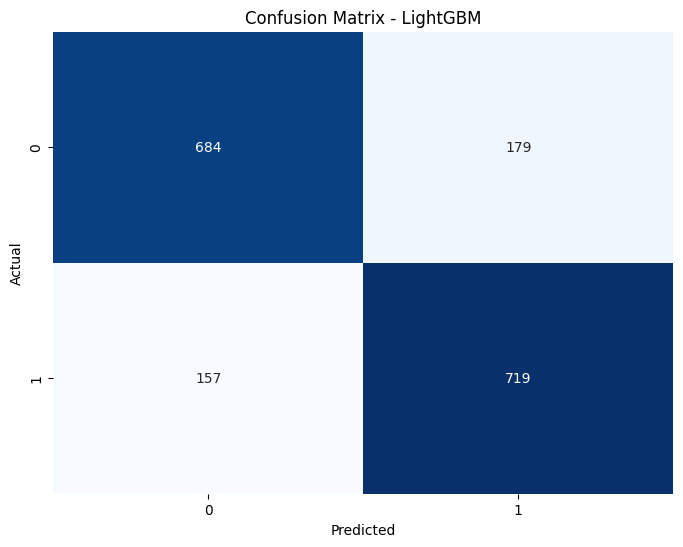

In [28]:
# Calculate and plot confusion matrix
cm = confusion_matrix(y_val_np, y_val_pred_binary)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix - LightGBM')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

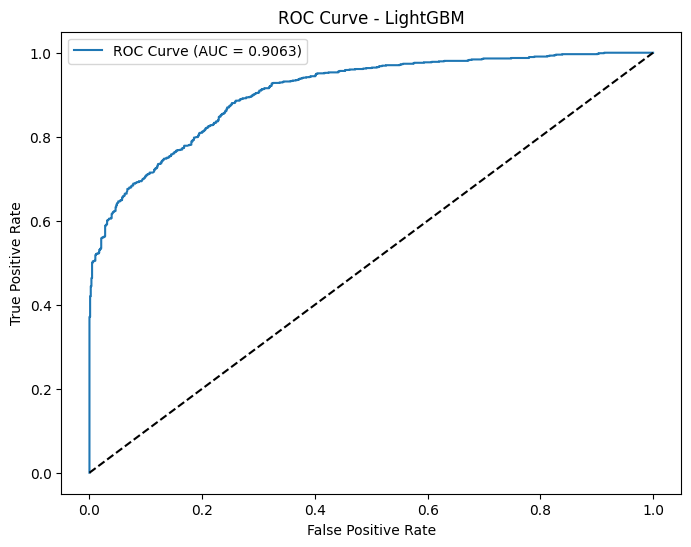

In [29]:
# Plot ROC curve
fpr, tpr, _ = roc_curve(y_val_np, y_val_pred)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - LightGBM')
plt.legend()
plt.show()


Calculating learning curve to check for overfitting/underfitting...


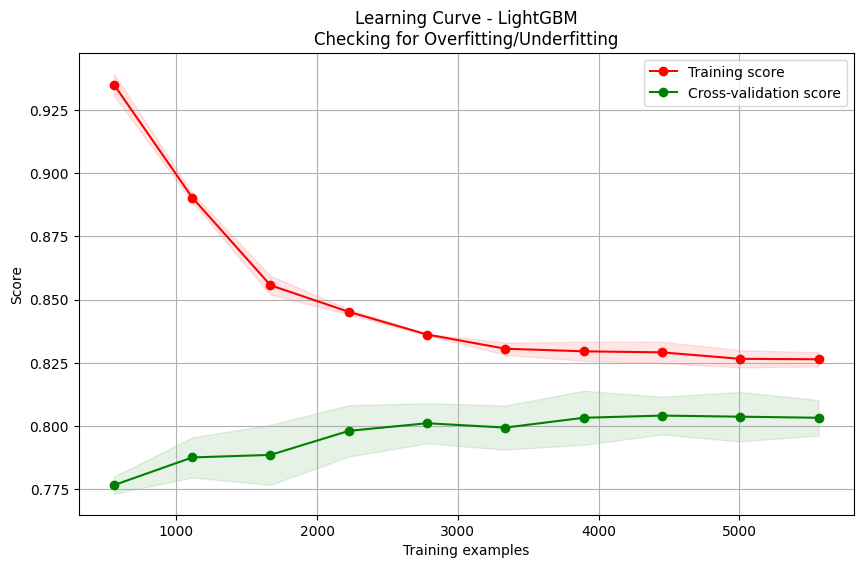

In [30]:
# Learning curve to check for overfitting/underfitting
print("\nCalculating learning curve to check for overfitting/underfitting...")

# Define a simpler LightGBM model for faster learning curve calculation
simple_lgb = lgb.LGBMClassifier(
    objective='binary',
    n_estimators=100,
    learning_rate=best_params['learning_rate'],
    max_depth=best_params['max_depth'],
    num_leaves=best_params['num_leaves'],
    random_state=RANDOM_STATE
)

# Calculate learning curve
train_sizes, train_scores, test_scores = learning_curve(
    simple_lgb, X_train, y_train_array, cv=5,
    scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10)
)

# Calculate mean and standard deviation for training and test scores
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

# Plot learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color='r', label='Training score')
plt.plot(train_sizes, test_mean, 'o-', color='g',
         label='Cross-validation score')
plt.fill_between(train_sizes, train_mean - train_std,
                 train_mean + train_std, alpha=0.1, color='r')
plt.fill_between(train_sizes, test_mean - test_std,
                 test_mean + test_std, alpha=0.1, color='g')
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.title('Learning Curve - LightGBM\nChecking for Overfitting/Underfitting')
plt.legend(loc='best')
plt.grid()
plt.show()


Analyzing feature importance...


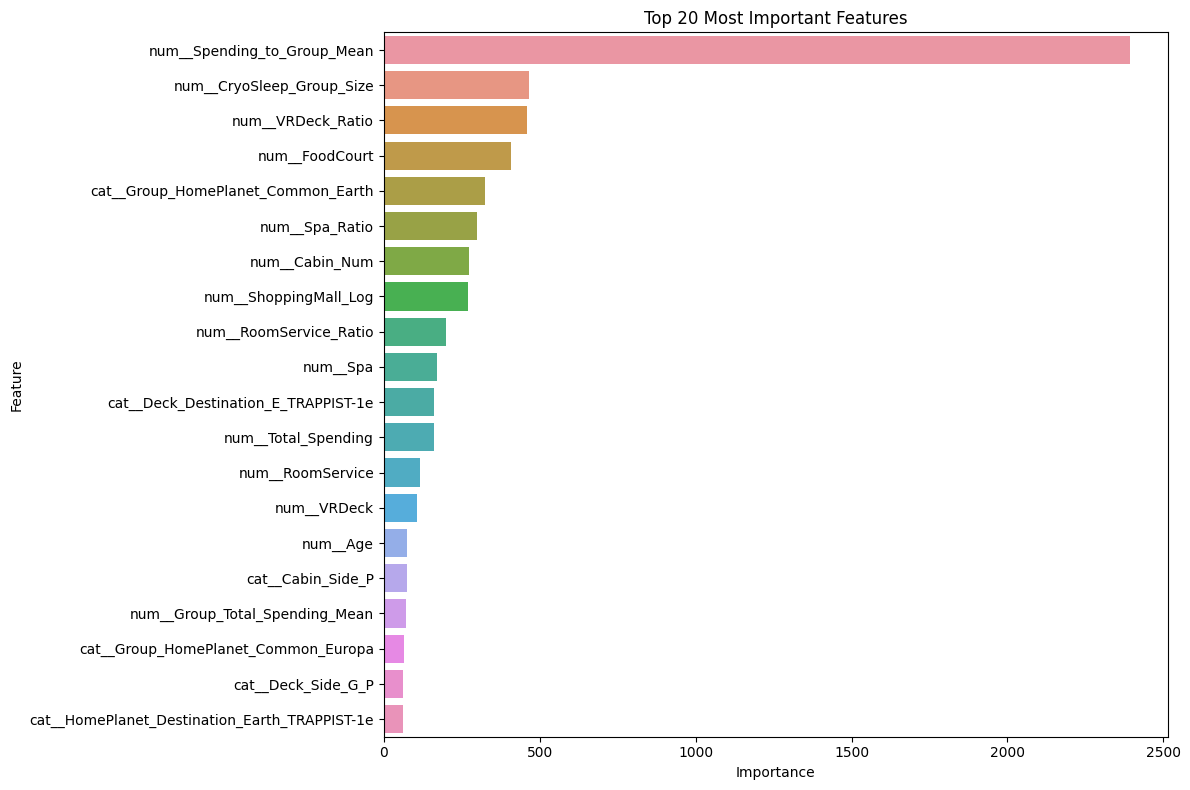

In [31]:
# Feature importance analysis
print("\nAnalyzing feature importance...")

# Get feature importance from the model using LightGBM's built-in methods
feature_importance = final_model.feature_importance(importance_type='gain')

# Get feature names (if available) or generate them
if hasattr(preprocessor, 'get_feature_names_out'):
    feature_names = preprocessor.get_feature_names_out()
else:
    num_feature_names = [f'num_{feat}' for feat in numerical_features]
    cat_feature_names = [f'cat_{i}' for i in range(
        X_train.shape[1] - len(num_feature_names))]
    feature_names = np.array(num_feature_names + cat_feature_names)

if len(feature_names) > X_train_selected.shape[1]:
    selected_indices = selector.get_support(indices=True)
    feature_names = feature_names[selected_indices]

# Create a DataFrame for visualization
importance_df = pd.DataFrame({
    'Feature': feature_names[:len(feature_importance)],
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
plt.title('Top 20 Most Important Features')
plt.tight_layout()
plt.show()

In [32]:
# Make predictions with the model
test_predictions = final_model.predict(X_test_selected)
test_predictions_binary = (test_predictions > 0.5).astype(bool)

# Create submission dataframe
submission = pd.DataFrame({
    'PassengerId': test_passenger_ids,
    'Transported': test_predictions_binary
})

# Save predictions to a CSV file
submission.to_csv('lgbm_submission.csv', index=False)

print("\nPredictions for test data saved to 'lgbm_submission.csv'")


Predictions for test data saved to 'lgbm_submission.csv'


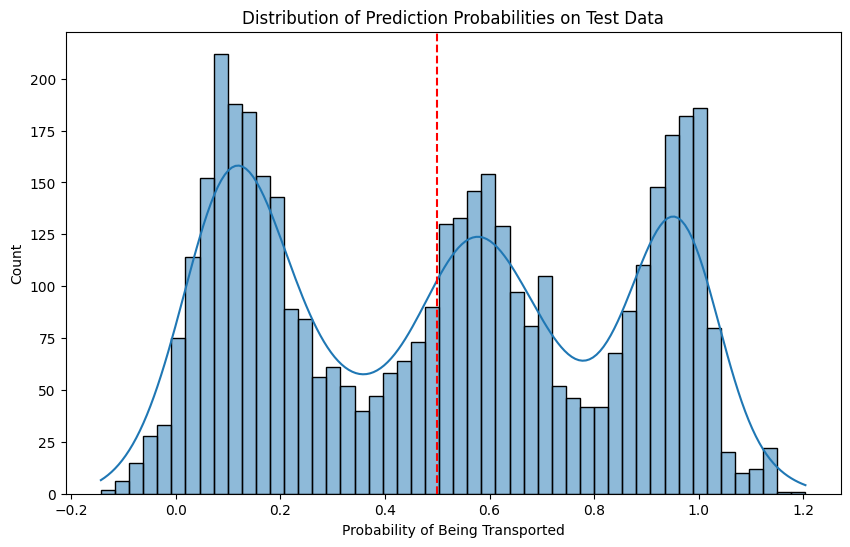

In [33]:
# Visualize prediction probabilities
plt.figure(figsize=(10, 6))
sns.histplot(test_predictions, bins=50, kde=True)
plt.axvline(x=0.5, color='red', linestyle='--')
plt.title('Distribution of Prediction Probabilities on Test Data')
plt.xlabel('Probability of Being Transported')
plt.ylabel('Count')
plt.show()